# Chapter 9 - Using Simulators and Quantum Device benchmarking


© 2021, 2022 Packt Publishing

Written by Alex Khan

In [1]:
# Enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-[your bucket]" # the name of the bucket
my_prefix = "[your folder]" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [3]:
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [4]:
import numpy as np

In [5]:
from scipy.optimize import minimize, curve_fit


In [6]:
# to check all gate operations refer to 
# https://docs.aws.amazon.com/braket/latest/developerguide/braket-constructing-circuit.html

https://docs.aws.amazon.com/braket/latest/developerguide/braket-constructing-circuit.html

In [7]:
def available_devices():
    from braket.aws import AwsDevice
    device_list=AwsDevice.get_devices(statuses=['ONLINE'])
    device_name_list=[]
    for device in device_list:
        device_name_list.append(device.name)
    #print('Valid device names: ',device_name_list)
    return(device_name_list)

In [8]:
def set_device(Name):
    device_list=AwsDevice.get_devices(names=Name)
    if len(device_list)==1:
        device=device_list[0]
        print(device)
        return(device)
    else:
        print('No device found')
        print('use name from list', available_devices())

In [9]:
def estimate_cost(device,num_shots=1000):
    #device=set_device(Name)
    cost_per_task=0.30
    Name=device.name
    if Name in ['SV1','TN1','dm1']:
        price_per_min=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('simulator cost per ',unit,': $', price_per_min)
        print('total cost cannot be estimated')
    elif Name in['Advantage_system6.1','Advantage_system4.1','DW_2000Q_6','Aspen-11','Aspen-M-1','IonQ Device']:
        price_per_shot=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('device cost per ',unit,': $', price_per_shot)
        print('total cost for {} shots is ${:.2f}'.format(num_shots,cost_per_task+num_shots*price_per_shot))
    else:
        print('device not found')
        print('use name from list', available_devices())


In [10]:
# This function was modified with a return of num_shots
def estimate_cost_measured_qubits(device,measured_qubits):
    #device=set_device(Name)
    min_shots_per_variable=25
    max_shots=device.properties.service.shotsRange[1]
    print('max shots:', max_shots)
    num_shots=min_shots_per_variable*2**measured_qubits
    if num_shots>max_shots:
        num_shots=max_shots
        print('for {} measured qubits the maximum allowed shots: {:,}'.format(measured_qubits,num_shots))
    else:
        print('for {} measured qubits the number of shots recommended: {:,}'.format(measured_qubits,num_shots))
    estimate_cost(device,num_shots)
    return(num_shots)

In [11]:
def actual_simulator_cost(device, result):
        price_per_min=device.properties.service.deviceCost.price
        price_per_ms=price_per_min/60/1000
        unit=device.properties.service.deviceCost.unit
        duration_ms=result.additional_metadata.simulatorMetadata.executionDuration
        if unit=='minute':
            print('simulator cost per ',unit,': $', price_per_min)
            print('total execution time: ', duration_ms, "ms")
            print('total cost estimated: $',duration_ms*price_per_ms)

In [12]:
# this function has been updated from the function in past chapters
def run_circuit(circuit, shots, local=True, device_name='', s3_folder='', display_binary=False, disable_qubit_rewiring=False):
    import matplotlib.pyplot as plt
    %matplotlib inline
    if local==True:
        device = LocalSimulator()
        result = device.run(circuit, shots=shots).result()
    else:
        device=set_device(device_name)
        if shots==0:
            measured_qubits=len(circuit.qubits)
            num_reads=estimate_cost_measured_qubits(device,measured_qubits)
        else:
            num_reads=shots
        print('device', device)
        print('num reads', num_reads)
        if device_name=='Aspen-11' or device_name=='Aspen-M-1':
            result = device.run(circuit, shots=num_reads, s3_destination_folder=s3_folder, disable_qubit_rewiring=disable_qubit_rewiring).result()
        else:
            result = device.run(circuit, shots=num_reads, s3_destination_folder=s3_folder).result()
        if device_name in (['SV1','TN1']):
            actual_simulator_cost(device, result)
        else:
            estimate_cost(device, num_reads)
    counts = result.measurement_counts
    if display_binary==True:
        print(counts)
        plt.bar(int(counts.keys(),2), counts.values());
        plt.xlabel('states');
        plt.ylabel('counts');
    else:
        x_val=[]
        y_val=[]
        dec_counts={}
        for i in (counts.keys()):
            x_val.append(int(i,2))
        for i in (counts.values()):
            y_val.append(i)
        for i in range(len(x_val)):
            dec_counts[x_val[i]]=y_val[i]
        print(dec_counts)
        plt.bar(x_val, y_val)

        plt.xlabel('states');
        plt.ylabel('counts');
    
    return(result)

In [13]:
def draw_bloch(q, info=True):
    #©2021-2 Alex Khan
    
    import matplotlib.pyplot as plt
    import numpy as np

    if q.shape != (2,1):
        print('Matrix must be only for one qubit')
        print('Shape needed (2,1). Shape given ',q.shape)
        return
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect("auto")
    if info==True:
        print('Matrix:')
        print(q)
    # draw Bloch Sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, color="y", alpha=0.2)

    u = np.linspace(0, 2* np.pi, 100)

    ax.plot(np.sin(u),np.cos(u),0*(u),color='y')
    ax.plot(0*(u),np.sin(u),np.cos(u),color='y')
    ax.plot(np.sin(u),0*(u),np.cos(u),color='y')

    # draw axes
    ax.plot([0,0],[1,-1],[0,0], color='y', linestyle='dotted')
    ax.plot([1,-1],[0,0],[0,0], color='y', linestyle='dotted')
    ax.plot([0,0],[0,0],[1,-1], color='y', linestyle='dotted')

    # draw state labels
    ax.annotate("|0>", xy=(0.0, 0.04), xytext=(0.0, 0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|1>", xy=(0.0, -0.04), xytext=(0.0, -0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|+>", xy=(-0.025, -0.022), xytext=(-0.06, -0.04), arrowprops=dict(arrowstyle="->"), color='y')

    # calculate vector
    
    r0=((q[0].real)**2+(q[0].imag)**2)**0.5
    #print('r0=',r0)
    if r0==0:
        phi0=0
    else:
    
        phi0=np.arccos(q[0].real/r0)
    
    r1=((q[1].real)**2+(q[1].imag)**2)**0.5
    #print('r1=',r1)
    if r1==0:
        phi1=0
    else:
    
        phi1=np.arccos(q[1].real/r1)
    r=(r0**2+r1**2)**0.5
    
    if(r<0.999 or r>1.0001):
        print('vector is  not normalized.  Cannot draw')
        return
    
    if np.sin(q[1].imag)<0:
        s1=-1
    else:
        s1=+1#

    if np.sin(q[0].imag)<0:
        s0=-1
    else:
        s0=+1
    

    #print('phi1',phi1,'phi0', phi0)
    phi=s1*phi1-s0*phi0   


    theta=2*np.arccos((q[0].real**2+q[0].imag**2)**0.5)
    
    v_x = np.cos(phi)*np.sin(theta)
    v_y = np.sin(phi)*np.sin(theta)


    v_z = np.cos(theta)
    v_z2= np.sin(theta)
    #print('theta',theta, 'phi',phi)

    #print('vx=cos(phi)',np.cos(phi), 'x sin(theta)', np.sin(theta),'= ',v_x)
    #print('vy=sin(phi)',np.sin(phi), 'x sin(theta)', np.sin(theta),'= ',v_y )
    #print('vz=cos(theta)', v_z)
    
    # print state
    if info==True:
        print(' ')
        print('State Vector: |psi> = sqrt(', q[0].real**2+q[0].imag**2, ') |0> + ( sqrt(', q[1].real**2+q[1].imag**2,')) e^i', phi/np.pi,'pi |1>')
        print(' ')
    # draw vector
    ax.quiver(0,0,0,v_y, -v_x, v_z, color='r')
    #print('cartesian coordinates on Bloch Sphere')
    #print(v_x, v_y, v_z)
    plt.axis('off')
    fig.set_size_inches(7, 7)
    #ax.view_init(10, 10, 10)
    #print('Bloch Sphere:')
    plt.show()
    return(q)

In [14]:
def draw_circuit(circ, info=True):
    # this function is only for one qubit and draws the Bloch sphere
    circ=circ.state_vector()
    if info==True:
        print(circ)
    device = LocalSimulator()
    result = device.run(circ).result()
    arr_r=np.array([[result.values[0][0]],[result.values[0][1]]])
    draw_bloch(arr_r, info)

In [15]:
def qft_gate(qc,qubits_needed):
    
    power=0

    for target in range(qubits_needed-1,-1,-1):
        qc.h(target)
        for control in range(target-1,-1,-1):
 
            power=target-control

            qc.cphaseshift(control, target, (np.pi/(2**(power))))


    #reverse qubits

    #for i in range (int(qubits_needed/2)):
        
        #qc.swap(i,qubits_needed-i-1)
    return(qc)

In [16]:
def qft_inv_gate(qc, qubits_needed, q_start=0):
    
    power=0

    for target in range(0,qubits_needed):
        
        for control in range(0,target):

            power=target-control

            qc.cphaseshift(control+q_start, target+q_start, -(np.pi/(2**(power))))
        
        qc.h(target+q_start)
    
    for i in range (int(qubits_needed/2)-1,-1,-1):
        
        qc.swap(i+q_start,qubits_needed-i-1+q_start)

    return(qc)

In [17]:
def draw_multi_qubit_phase(Qubits, Number, add_hadamard=True):

    b_Number=format(Number, '0'+str(Qubits)+'b')

    print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number)
    # qc builds the full circuit 
    # circ is only a qubit by qubit model for showing the bloch sphere
    qc=Circuit()
    for q in range(Qubits):
        print('qubit',q)
        circ=Circuit().h(0)
        
        if add_hadamard==True:
            qc=qc.h(q)
        p=0
        for i in range(Qubits-q-1,Qubits):

            if b_Number[i]=='1':
                circ.phaseshift(0,np.pi/(2**p))
                qc.phaseshift(q,np.pi/(2**p))

            p+=1
        # draw the bloch sphere for each qubit
        draw_circuit(circ, False) 
    return(qc)
        
        
    

In [18]:
def qc_num(num, qubits_needed):
    qubits_format='0'+str(qubits_needed)+'b'
    n_bin=format(num, qubits_format)

    qubits_needed=len(n_bin)

    qc=Circuit()
    for i in range(qubits_needed):
        if n_bin[i]=='1':
            #reverse number
            #qc.x(qubits_needed-i-1)
            qc.x(qubits_needed-i-1)


    return(qc)

In [19]:
def add_coefficient(qc, q_start, Qubits, control_qubit, Number):
    b_Number=format(Number, '0'+str(Qubits)+'b')

    #print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number, q_start, control_qubit)


    for q in range(Qubits):
        #print('qubit',q)

        p=0
        for k in range(Qubits-q-1,Qubits):

            if b_Number[k]=='1':

                qc.cphaseshift(control_qubit,q+q_start,np.pi/(2**p))

            p+=1

    return(qc)

In [20]:
def subtract_coefficient(qc, q_start, Qubits, control_qubit, Number):
    b_Number=format(Number, '0'+str(Qubits)+'b')

    #print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number, q_start, control_qubit)


    for q in range(Qubits):
        #print('qubit',q)

        p=0
        for k in range(Qubits-q-1,Qubits):

            if b_Number[k]=='1':

                qc.cphaseshift(control_qubit,q+q_start,-np.pi/(2**p))

            p+=1

    return(qc)

In [21]:
def matrix_to_polynomial(objective):
    #Qubits=3    
    #objective=np.array([[2,-1],[0,3]])
    eq=''
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
    len_r1=len(objective)

    #extra_qubits={}
    #r2=len_r1
    ex_qu=0

    for i in range (len_r1):
        if objective[i,i]<0:
            eq=eq+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)
        elif objective[i,i]>0:
            eq=eq+'+'+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)

    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:

                if objective[i,j]<0:
                    #extra_qubits[(i,j)]=r2
                    #r2+=1
                    eq=eq+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
                elif objective[i,j]>0:
                    #extra_qubits[(i,j)]=r2
                    #r2+=1                
                    eq=eq+'+'+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
    print(eq)
    return(eq)

In [22]:
def multi_qubit_polynomial(Qubits, objective):
    #Qubits=3    
    #objective=np.array([[2,-1],[0,3]])
    eq=''
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
    len_r1=len(objective)

    extra_qubits={}
    r2=len_r1
    ex_qu=0

    for i in range (len_r1):
        if objective[i,i]<0:
            eq=eq+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)
        elif objective[i,i]>0:
            eq=eq+'+'+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)

    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:

                if objective[i,j]<0:
                    extra_qubits[(i,j)]=r2
                    r2+=1
                    eq=eq+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
                elif objective[i,j]>0:
                    extra_qubits[(i,j)]=r2
                    r2+=1                
                    eq=eq+'+'+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
    print(eq)
    # starting qubit for register 2

    q_start=r2

    qc=Circuit()

    #qc=qc.x(1).x(0)
    qc=qc.h(np.arange(len_r1))


    for q in range(Qubits):
        qc=qc.h(q+q_start)


    for i in range (len_r1):
        if objective[i,i]<0:
            qc=subtract_coefficient(qc, q_start, Qubits, i, objective[i,i])
        elif objective[i,i]>0:
            qc=add_coefficient(qc, q_start, Qubits, i, objective[i,i])
    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:
                if objective[i,j]<0:
                    qc=qc.ccnot(i,j,extra_qubits[i,j])
                    qc=subtract_coefficient(qc, q_start, Qubits, extra_qubits[i,j], objective[i,j])
                elif objective[i,j]>0:
                    qc=qc.ccnot(i,j,extra_qubits[i,j])
                    qc=add_coefficient(qc, q_start, Qubits, extra_qubits[i,j], objective[i,j])

    qc=qft_inv_gate(qc, Qubits, q_start ) 

    
    return(qc, len_r1, q_start)

In [23]:
def plot_results_mc(counts):

    figure(figsize=(10, 6), dpi=100)

    len1=len(objective)
    print('valid values',-max_val/2,'to',max_val/2)
    x_val=[]
    y_val=[]
    cost=[]
    #print(len1,Qubits)
    for val in zip(counts.values(), counts.keys()):
        result=int(val[1][q_start:q_start+Qubits],2)
        #print(val[1], val[1][0:len1], result, val[0])
        if result <= max_val/2:


            x_val.append(str(val[1][0:len1])+'('+str(result)+')')
            y_val.append(val[0])
            cost.append(result)
        else:
            x_val.append(str(val[1][0:len1])+'('+str(result-max_val)+')')
            y_val.append(val[0])
            cost.append(result-max_val)        

    sort_index = np.argsort(cost)
    x_val = [x_val[i] for i in sort_index]
    y_val = [y_val[i] for i in sort_index]
    cost = [cost[i] for i in sort_index]

    print('from lowest to highest value')
    print('input (cost) count')
    print('-----  ----- -----')
    for i in range(len(x_val)):
        print(x_val[i], y_val[i])

    plt.bar(x_val, y_val)
    plt.xlabel('value')
    plt.ylabel('counts')
    plt.xticks(rotation = 89) # Rotates X-Axis Ticks by 45-degrees
    plt.show()

In [24]:
def sum_energy(Q,array):
    vals=[]
    for i in range(len(array)):
        if array[int(i)]=='1':
            vals.append(i)
            
    sum=0
    #print(vals)
    for i in (vals):
        sum+=Q[int(i),int(i)]
    for i in (vals):
        for j in (vals):
            if i<j:
                sum+=Q[int(i),int(j)]
    return(sum)
            
    

In [25]:

def param_optimizer(param1, param2, Q, shots):
    import seaborn as sns
    lowest_energy=999999
    lowest_param1=0
    lowest_param2=0
    D=np.zeros((len(param1),len(param2)))


    for p1 in range(len(param1)):
        for p2 in range(len(param2)):

            qc=Circuit()
            qc=qc.x(range(len(Q))).h(range(len(Q)))
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rz(i,-2*param1[p1]*Q[i,i])
            for i in range (len(Q)):
                for j in range (len(Q)):
                    if i<j:
                        if Q[i,j]!=0:
                            qc=qc.zz(i,j,2*param1[p1]*Q[i,j])
            for i in range(len(Q)):
                qc=qc.rx(i,2*param2[p2])
            print(qc)
            

            device = LocalSimulator()
            result = device.run(qc, shots=shots).result()
            counts = result.measurement_counts

            solution=[]
            quantity=[]
            energy=[]
            for keys,values in zip(counts.keys(),counts.values()):
                solution.append(keys)
                quantity.append(values)
                energy.append(sum_energy(Q,keys))
            index=np.argsort(energy)

            #plt.scatter(energy,quantity)   
            #plt.show()
            D[p1,p2]=energy[index[0]]
            if energy[index[0]]<lowest_energy:
                lowest_energy=energy[index[0]]
                lowest_param1=param1[p1]
                lowest_param2=param2[p2]
            

            #print(p1,p2,'lowest',energy[0])
    plt.figure(1, figsize=[7, 5])
    sns.heatmap(D, annot=True,  linewidths=.5, cmap="YlGnBu", annot_kws = {'alpha': 1})
    plt.title('parameter landscape');
    plt.tight_layout();
    return(lowest_param1, lowest_param2, lowest_energy)

In [26]:
def param_optimizer_device(param1, param2, Q, shots,device_name):
    import seaborn as sns
    lowest_energy=999999
    lowest_param1=0
    lowest_param2=0
    D=np.zeros((len(param1),len(param2)))


    for p1 in range(len(param1)):
        for p2 in range(len(param2)):

            qc=Circuit()
            
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    #print(i,Q[i,i])
                    qc=qc.x(i).h(i)
            
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rz(i,-2*param1[p1]*Q[i,i])
            for i in range (len(Q)):
                for j in range (len(Q)):
                    if i<j:
                        if Q[i,j]!=0:
                            if device_name=='Aspen-11' or device_name=='Aspen-M-1' :
                                qc=qc.cnot(i, j).rz(j, param1[p1]*Q[i,j]).cnot(i, j)
                            else:
                                qc=qc.zz(i,j,2*param1[p1]*Q[i,j])
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rx(i,2*param2[p2])
            print(qc)
            

            result=run_circuit(qc, shots, False, device_name, s3_folder, False, True)
            counts = result.measurement_counts
            
            solution=[]
            quantity=[]
            energy=[]
            for keys,values in zip(counts.keys(),counts.values()):
                solution.append(keys)
                quantity.append(values)
                energy.append(sum_energy(Q,keys))
            index=np.argsort(energy)

            #plt.scatter(energy,quantity)   
            #plt.show()
            D[p1,p2]=energy[index[0]]
            if energy[index[0]]<lowest_energy:
                lowest_energy=energy[index[0]]
                lowest_param1=param1[p1]
                lowest_param2=param2[p2]
            

            #print(p1,p2,'lowest',energy[0])
    plt.figure(1, figsize=[7, 5])
    sns.heatmap(D, annot=True,  linewidths=.5, cmap="YlGnBu", annot_kws = {'alpha': 1})
    plt.title('parameter landscape');
    plt.tight_layout();
    return(lowest_param1, lowest_param2, lowest_energy)

In [27]:
def schedule_task(qc, shots, device):
    qc_task = device.run(qc, s3_folder, shots=shots, poll_timeout_seconds=5*24*60*60)
    qc_status = qc_task.state()
    print('ID of task:', qc_task.id)
    print('Status of task:', qc_status)
    
    # to retrieve task use
    # results, metadata, counts=recover_task_sum(qc_task_id)
    return(qc_task.id)

In [28]:
def recover_task(task_id):
    # recover task
    task_load = AwsQuantumTask(arn=task_id)

    # print status
    status = task_load.state()
    #print('Status of (reconstructed) task:', status)

    # wait for job to complete
    # terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
    if status == 'COMPLETED':
        # get results
        results = task_load.result()
        # print(rigetti_results)

        # get all metadata of submitted task
        metadata = task_load.metadata()
        # example for metadata
        shots = metadata['shots']
        machine = metadata['deviceArn']
        # print example metadata
        print("{} shots taken on machine {}.".format(shots, machine))

        # get measurement counts
        counts = results.measurement_counts
        #print('Measurement counts:', counts)

        return(results, metadata, counts)
       
       

    elif status in ['FAILED', 'CANCELLED']:
        # print terminal message 
        print('Your task is in terminal status, but has not completed.')

    else:
        # print current status
        print('Sorry, your task is still being processed and has not been finalized yet.')

In [51]:
def schedule_optimize_bqm_task(param1, param2, Q, shots, device):
    
    qc=Circuit()
    qc=qc.x(range(len(Q))).h(range(len(Q)))

    for p in range(len(param1)):
        for i in range(len(Q)):
            if Q[i,i]!=0:
                qc=qc.rz(i,-2*param1[p]*Q[i,i])
        for i in range (len(Q)):
            for j in range (len(Q)):
                if i<j:
                    if Q[i,j]!=0:
                        if device.name=='Aspen-11' or device_name=='Aspen-M-1' :
                            qc=qc.cnot(i, j).rz(j, param1[p]*Q[i,j]).cnot(i, j)
                        else:
                            qc=qc.zz(i,j,2*param1[p]*Q[i,j])
        for i in range(len(Q)):
            qc=qc.rx(i,2*param2[p])
    
    qc_task_id=schedule_task(qc, shots, device)
    
    return(qc_task_id)


In [30]:
# |0> state
arr_0=np.array([[1+0j],[0+0j]])
# |1> state
#arr_1=np.array([[0],[1]])
arr_1=np.array([[0+0j],[1+0j]])


# i operator
arr_i=np.array([[1,0],[0,1]])
# x operator
arr_x=np.array([[0,1],[1,0]])
# y operator
arr_y=np.array([[0,-1j],[1j,0]])
# z opeator
arr_z=np.array([[1,0],[0,-1]])
# h operator
arr_h=(1/np.sqrt(2))*(np.array([[1, 1],[1, -1]]))
# t operator
arr_t=np.array([[1,0],[0,np.exp(1j*np.pi/4)]])
# s operator
arr_s=np.array([[1,0],[0,np.exp(1j*np.pi/2)]])

In [31]:
def func_bqm(x):
    # This function is used by the scipy optimizer
    # It takes a matrix Q and returns the lowest energy found for a single set of parameters in x
    # It allows scipy to find the optimal single set of parameters
    #
    global Q
    global shots
    global param1_list
    global param2_list
    global min_value_list
    global quantity_list
    global solution_list
    global SV
    param1=x[0]
    param2=x[1]
    sum=0
    qc=Circuit()
    
    Qubits=len(Q)
    qc=qc.x(range(Qubits)).h(range(Qubits))
    for i in range(Qubits):
        if Q[i,i]!=0:
            qc=qc.rz(i,-2*param1*Q[i,i])
    for i in range (Qubits):
        for j in range (Qubits):
            if i<j:
                if Q[i,j]!=0:
                    qc=qc.zz(i,j,2*param1*Q[i,j])
    for i in range(len(Q)):
        qc=qc.rx(i,2*param2)
    
    device = LocalSimulator()
    solution=[]
    quantity=[]
    energy=[]
    
    if SV==True:
        qc=qc.state_vector()
        result = device.run(qc, shots=0).result()
        #print(result.values)
        counter=0
        for res in (result.values[0]):
            quantity.append(abs(res)**2)
            keys=format(counter, '0'+str(Qubits)+'b')
            #print(keys)
            solution.append(keys)
            counter+=1
            energy.append(sum_energy(Q,keys))

    else:
        result = device.run(qc, shots=shots).result()
        counts = result.measurement_counts

        for keys,values in zip(counts.keys(),counts.values()):
            solution.append(keys)
            quantity.append(values)
            energy.append(sum_energy(Q,keys))
    
    index=np.argsort(energy)
    param1_list.append(param1)
    param2_list.append(param2)
    min_value_list.append(energy[index[0]])
    solution_list.append(solution[index[0]])
    quantity_list.append(quantity[index[0]])
    return(energy[index[0]])

In [32]:
def optimize_bqm(param1, param2, Q, shots):
    # This function optimizes 
    qc=Circuit()
    qc=qc.x(range(len(Q))).h(range(len(Q)))

    for p in range(len(param1)):
        for i in range(len(Q)):
            if Q[i,i]!=0:
                qc=qc.rz(i,-2*param1[p]*Q[i,i])
        for i in range (len(Q)):
            for j in range (len(Q)):
                if i<j:
                    if Q[i,j]!=0:
                        qc=qc.zz(i,j,2*param1[p]*Q[i,j])
        for i in range(len(Q)):
            qc=qc.rx(i,2*param2[p])


    device = LocalSimulator()
    result = device.run(qc, shots=shots).result()
    counts = result.measurement_counts
    solution=[]
    quantity=[]
    energy=[]
    for keys,values in zip(counts.keys(),counts.values()):
        solution.append(keys)
        quantity.append(values)
        energy.append(sum_energy(Q,keys))
    energy_np=np.array(energy)
    index=np.argsort(energy)
    
    
    plt.title('param1:'+str(param1)+' param2:'+str(param2))
    plt.xlabel('cost')
    #plt.xlim(-3, 8)
    plt.ylabel('occurrence')
    #plt.ylim(0,2700)
    plt.scatter(energy,quantity)

    plt.show()
    return(solution[index[0]],energy[index[0]],quantity[index[0]])


In [33]:
def ProbabilisticSampler(Q,plot_limit,offset=0, min_limit=0, max_limit=0):
    #(C) 2021, 2022 Alex Khan 

    
    from itertools import combinations
    import numpy as np
    import pandas as pd
    import random
    import math
    import matplotlib.pyplot as plt
    
    def nCr(n,r):
        f = math.factorial
        return int(f(n) / f(r) / f(n-r))
    
    def random_combination(iterable, r):
        "Random selection from itertools.combinations(iterable, r)"
        pool = tuple(iterable)
        n = len(pool)
        indices = sorted(random.sample(range(n), r))
        return list(tuple(pool[i] for i in indices))
    
    def sum(i_list, Q):
        sum_lq=0

        for i in (i_list):
            for j in (i_list):
                
                sum_lq+=Q[i][j]
            
        return(sum_lq+offset)
    
    
    N=len(Q[0])
    if max_limit==0:
        max_limit=N
    t= (2**N)-1
    
    e_min=9999999
    count=0
    min_list=[]
    plot_data=[]
    x_label=[]
    comb_list=[]
    for n in range(min_limit,max_limit+1):  # for groups of items from 1 to N
        comb=nCr(N,n)
        comb_list.append(comb)
        #print('--m ', m, comb)
        if comb>plot_limit:
            combf=plot_limit
        else:
            combf=comb
                
        for i in range (combf):
            i_list=random_combination(range(N), n)
            plot_data.append(sum(list(i_list),Q))
            x_label.append(n)
            
            if sum(list(i_list),Q)<e_min:  

                    e_min=sum(list(i_list),Q)  
                    min_count=n
                    min_list=list(i_list)
                    
                    #print(list(i_list), sum(list(i_list),Q))
            count+=1
    plt.plot(x_label,plot_data)
    plt.ylabel('Energy')
    plt.show()
    
    print('Best found:', min_list)
    print('count:', min_count)
    print('Energy:', e_min)
    print('Solutions Sampled:', count)
    #print('Total Possible solutions:', comb_list)
    return min_list, e_min, comb_list

In [34]:
def run_dwave(Q):
    from braket.aws import AwsDevice
    from braket.ocean_plugin import BraketSampler, BraketDWaveSampler
    from dwave.system.composites import EmbeddingComposite
    import dimod 
    # device
    # DWave_device='DW_2000Q_6' #if using 2000Q
    #DWave_device='Advantage_system4.1' #if using advantage
    DWave_device='Advantage_system6.1' #if using advantage
    
    device =AwsDevice.get_devices(names=DWave_device)[0]
    
    # sampler properties
    sampler = BraketDWaveSampler(s3_folder,device.arn)
    sampler = EmbeddingComposite(sampler)
    max_shots=device.properties.service.shotsRange[1]
    print('Number of qubits: ', device.properties.provider.qubitCount)
    print('Number of couplers', len(device.properties.provider.couplers))
    print('Shots max {:,}'.format(max_shots) )
    
    #Estimate cost and shots
    dim=len(Q)
    shots=25*2**dim
    print(shots)
    if shots>max_shots:
        shots=max_shots
    price_per_shot=device.properties.service.deviceCost.price
    print('Recommended shots', shots)
    print('Estimated cost ${:.2f}'.format(0.3+price_per_shot*shots))
    
    # create BQM
    linear={i:Q[i][i] for i in range(dim)}
    quadratic={(i,j):Q[i][j] for i in range(dim) for j in range(dim) if i<j}
    
    vartype = dimod.BINARY
    bqm = dimod.BinaryQuadraticModel(linear, quadratic, vartype)
    
    # Note: reduce shots if you want to reduce costs
    shots=shots
    chain_strength = 1.3
    
    # run sampler
    response = sampler.sample(bqm, num_reads=shots, chain_strength=chain_strength)
                              
    print(response)
                              
    solution=""
    for i in response:
        print(i)
        for s in i:
            solution=solution+str(i[s])
        break
    print(solution)
    print('decimal equivalent:',int(solution,2))
                              
    print('Validate energy',sum_energy(Q,solution))
    return(response)

In [35]:
def run_neal(Q):
    import neal
    import dimod 
    Nsampler = neal.SimulatedAnnealingSampler()
    QDWaveSA = dimod.BinaryQuadraticModel(Q, dimod.BINARY)
    SAresponse = Nsampler.sample(QDWaveSA)
    for SAsample in SAresponse.data():
        print( SAsample)
    solution=""
    for i in SAresponse:
        print(i)
        for s in i:
            solution=solution+str(i[s])
        break
    print(solution)
    print(int(solution,2))
    return(SAresponse)

In [100]:
def create_aspen_11_matrix():
    import networkx as nx
    import matplotlib.pyplot as plt
    import random

    device=set_device('Aspen-11')
    aspen_graph = device.properties.paradigm.connectivity.connectivityGraph
    #print(f"the connectivity of {device.name} is: {aspen_graph}")


    G = nx.Graph()
    A=np.zeros((48,48))
    for i in aspen_graph:
        G.add_node(i)
        #print(i)
        A[int(i),int(i)]=-random.randrange(1,5)
        for j in (aspen_graph[i]):
            #print(i,j)
            if int(i)<=int(j):
                A[int(i),int(j)]=random.randrange(1,20)/10
                G.add_edge(i,j)
            else:
                #print('flip')
                A[int(j),int(i)]=random.randrange(1,20)/10
                G.add_edge(j,i)

    #print(A)  
    #print(len(A))
    np.savetxt('Aspen_matrix.csv', A, delimiter=',')
    #print(nx.spring_layout(G))
    #subax1 = plt.subplot(121)
    #nx.draw(G) # default spring_layout
    subax2 = plt.subplot()
    nx.draw(G, pos=nx.spring_layout(G), node_shape='.', node_color='r', edge_color='b')


In [ ]:
def create_aspen_M-1_matrix():
    import networkx as nx
    import matplotlib.pyplot as plt
    import random

    device=set_device('Aspen-M-1')
    aspen_graph = device.properties.paradigm.connectivity.connectivityGraph
    #print(f"the connectivity of {device.name} is: {aspen_graph}")


    G = nx.Graph()
    A=np.zeros((48,48))
    for i in aspen_graph:
        G.add_node(i)
        #print(i)
        A[int(i),int(i)]=-random.randrange(1,5)
        for j in (aspen_graph[i]):
            #print(i,j)
            if int(i)<=int(j):
                A[int(i),int(j)]=random.randrange(1,20)/10
                G.add_edge(i,j)
            else:
                #print('flip')
                A[int(j),int(i)]=random.randrange(1,20)/10
                G.add_edge(j,i)

    #print(A)  
    #print(len(A))
    np.savetxt('Aspen_matrix.csv', A, delimiter=',')
    #print(nx.spring_layout(G))
    #subax1 = plt.subplot(121)
    #nx.draw(G) # default spring_layout
    subax2 = plt.subplot()
    nx.draw(G, pos=nx.spring_layout(G), node_shape='.', node_color='r', edge_color='b')


In [36]:
def generate_matrix(Qubits):
    #Generate a fixed matrix for desired number of Qubits
    import pandas as pd
    E = pd.read_csv("100x100.csv", header=None ).values
    if (len(E[0])==len(E[1])):
        dim=len(E)
        print(dim)
    Q=np.zeros((Qubits,Qubits))
    count=0
    for i in range(Qubits):
        for j in range(Qubits):
            if i<j:
                Q[i,j]=E[i,j]
            elif i==j:
                Q[i,j]=-E[i,j]
    return(Q)

In [95]:
def generate_sparse_matrix(Qubits):
    #Generate a fixed matrix for desired number of Qubits
    import pandas as pd
    terms=0
    E = pd.read_csv("100x100.csv", header=None ).values
    if (len(E[0])==len(E[1])):
        dim=len(E)
        print(dim)
    Q=np.zeros((Qubits,Qubits))
    count=0
    for i in range(Qubits):
        for j in range(Qubits):
            if i<j:
                if E[i,j]>3:
                    Q[i,j]=E[i,j]
                    terms+=1
                    
            elif i==j:
                Q[i,j]=-E[i,j]
                terms+=1
    print('terms:',terms)
    return(Q)

In [106]:
def convert_aspen_to_tn1(T_raw):
    RtoN={}
    counter=0
    for i in range(len(T_raw)):
        if T_raw[i,i]!=0:
            RtoN[i]=counter
            counter+=1
    print(RtoN)

    TN=np.zeros((len(RtoN), len(RtoN)))

    for i in range(len(T_raw)):
        if T_raw[i,i]!=0:
            TN[RtoN[i],RtoN[i]]=T_raw[i,i]

    for i in range(len(T_raw)):
        for j in range(len(T_raw)):
            if i<j and T_raw[i,j]!=0:
                TN[RtoN[i],RtoN[j]]=T_raw[i,j] 

    print(TN)
    print(TN.shape)
    return(TN)

## 1. Further QAOA Considerations

### Full QAOA Hybrid Algorithm using classical parameter optimizer

In [140]:
# Test Params

param1=np.arange(0.1,0.8,0.15,dtype=float)
param2=np.arange(0.1,0.8,0.15,dtype=float)
print(param1)
print(param2)

[0.1  0.25 0.4  0.55 0.7 ]
[0.1  0.25 0.4  0.55 0.7 ]


In [37]:
file = open("IonQ_matrix.csv")
Q = np.loadtxt(file, delimiter=",")
file.close()
print(Q)


[[ 1.3  -0.63 -0.34 -0.3   0.22  0.1   0.03 -0.5   0.28 -0.8  -0.1 ]
 [ 0.    0.51 -0.25  0.42  0.45  0.89  0.09 -0.8  -0.74 -0.68 -0.2 ]
 [ 0.    0.    0.84  0.03 -0.3   0.5  -0.22  0.7  -0.3   0.6   0.3 ]
 [ 0.    0.    0.    0.75  0.51 -0.2   0.25  0.3  -0.03  0.03  0.4 ]
 [ 0.    0.    0.    0.    0.27 -0.65 -0.4   0.2  -0.46  0.54 -0.2 ]
 [ 0.    0.    0.    0.    0.    0.15 -0.95  0.51  0.67 -0.22 -0.4 ]
 [ 0.    0.    0.    0.    0.    0.    0.35 -0.6   0.63  0.2   0.25]
 [ 0.    0.    0.    0.    0.    0.    0.    0.25 -0.81 -0.59 -0.4 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.5   0.01  0.3 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.6  -0.1 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.1 ]]


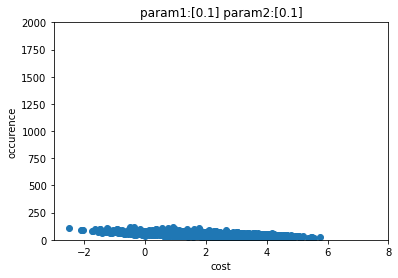

Parameters 0.1 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 109


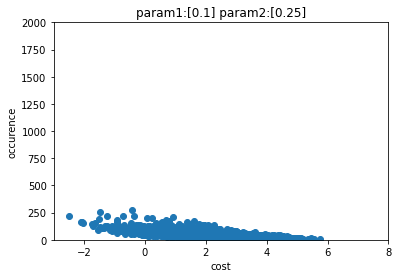

Parameters 0.1 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 223


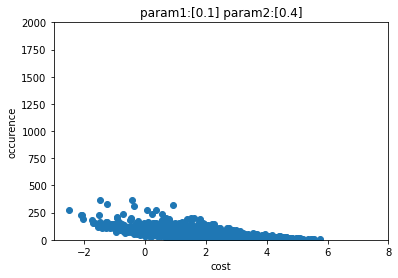

Parameters 0.1 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 272


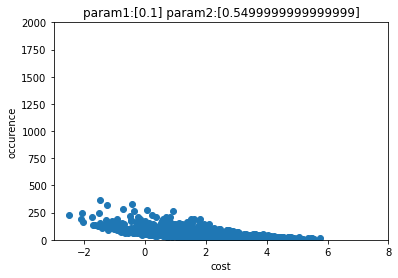

Parameters 0.1 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 231


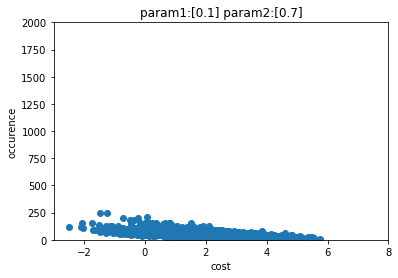

Parameters 0.1 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 115


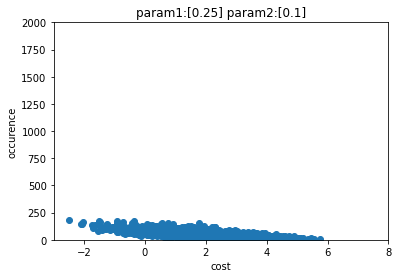

Parameters 0.25 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 179


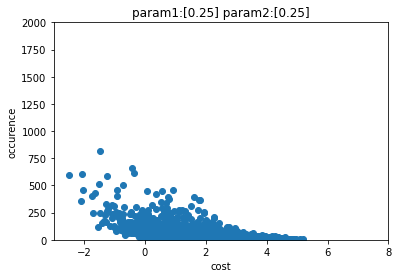

Parameters 0.25 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 599


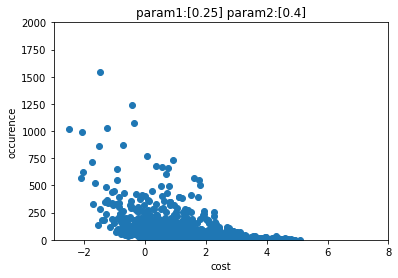

Parameters 0.25 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1015


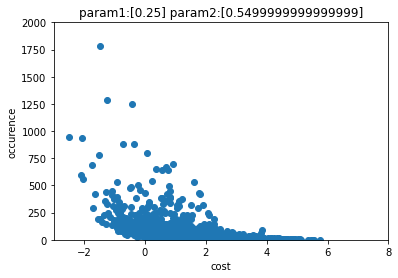

Parameters 0.25 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 948


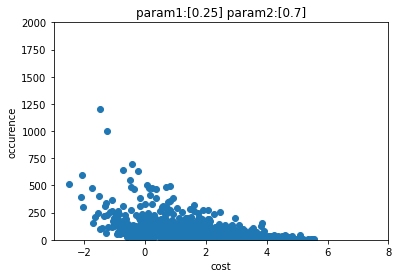

Parameters 0.25 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 516


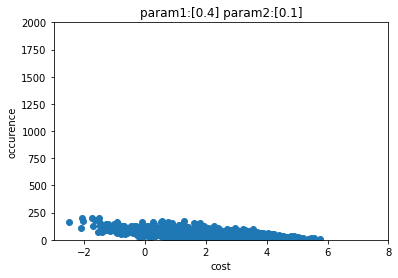

Parameters 0.4 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 163


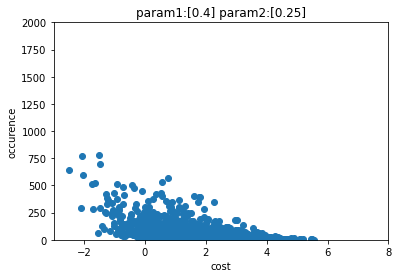

Parameters 0.4 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 646


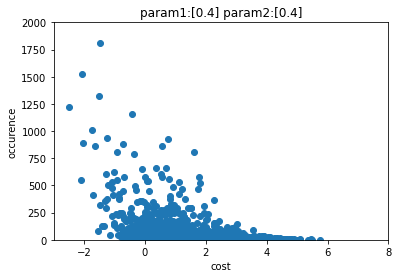

Parameters 0.4 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1223


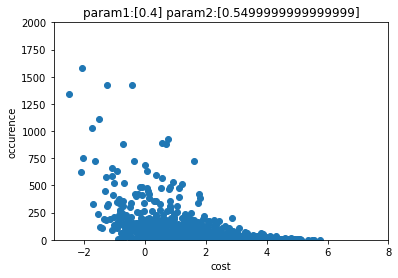

Parameters 0.4 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1344


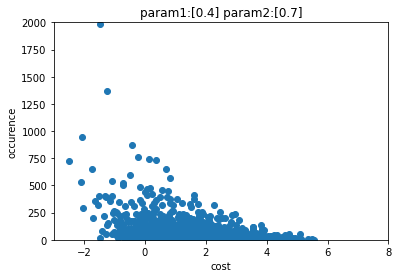

Parameters 0.4 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 726


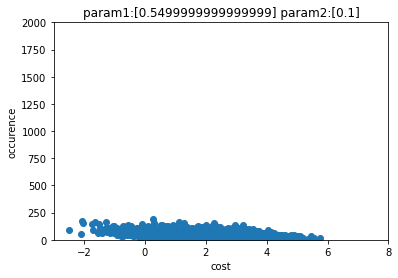

Parameters 0.5499999999999999 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 87


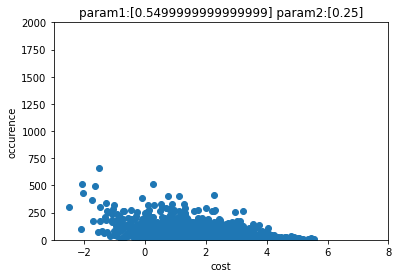

Parameters 0.5499999999999999 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 302


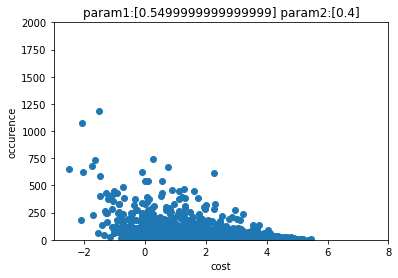

Parameters 0.5499999999999999 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 650


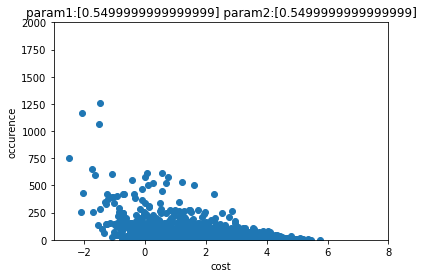

Parameters 0.5499999999999999 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 749


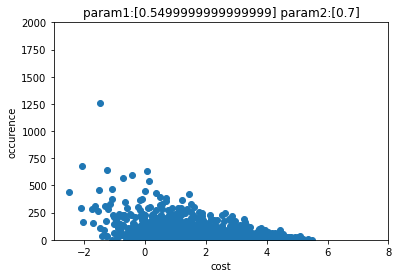

Parameters 0.5499999999999999 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 443


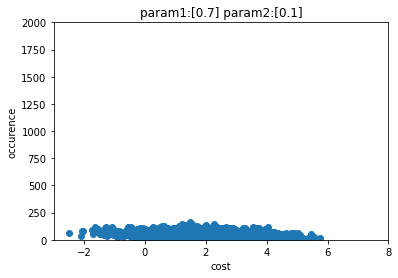

Parameters 0.7 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 65


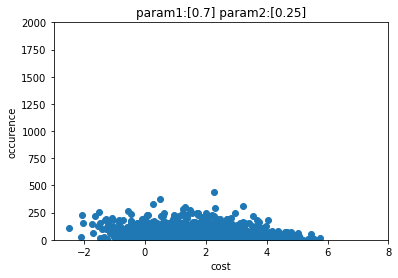

Parameters 0.7 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 110


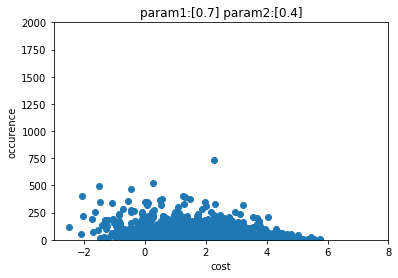

Parameters 0.7 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 120


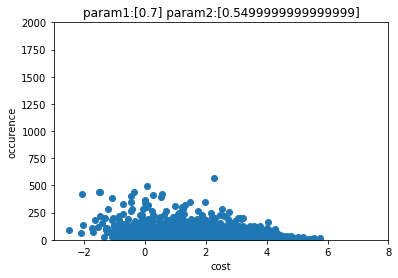

Parameters 0.7 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 90


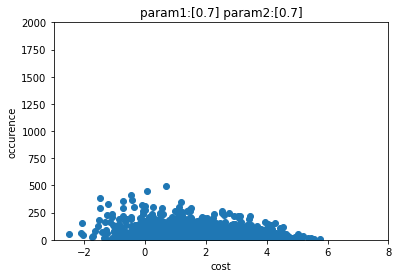

Parameters 0.7 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 54


In [142]:
for p1 in param1:
    for p2 in param2:
        solution,energy,quantity=optimize_bqm([p1], [p2], Q, 100000)
        print('Parameters', p1, p2, 'Solution:',solution, 'Energy:',energy, 'Qty Sampled',quantity)

T   : |0|1|    2     |    3     |    4     |         5         |         6         |             7             |              8              |                 9                  |                   10                   |                       11                       |                       12                        |                       13                       |                  14                   |                  15                  |              16              |             17              |        18         |        19         |   20   |   21    |  22   |
                                                                                                                                                                                                                                                                                                                                                                                                                                        

T   : |0|1|    2     |    3     |    4     |        5         |         6         |             7             |              8              |                 9                  |                   10                   |                      11                       |                       12                        |                       13                       |                  14                   |                  15                  |              16              |             17              |        18        |        19         |   20   |   21    |  22   |
                                                                                                                                                                                                                                                                                                                                                                                                                                           

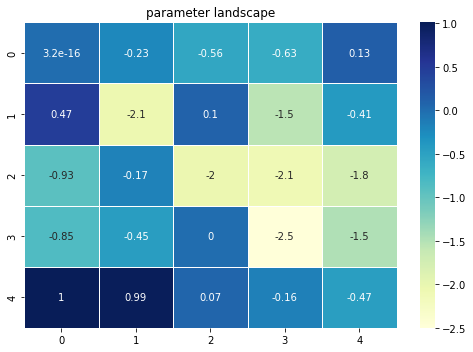

In [148]:
ideal_param1, ideal_param2, lowest_energy=param_optimizer(param1, param2, Q,10)

### Using Optimizer

In [167]:
shots=10
SV=False
Q=Q
param1_list=[]
param2_list=[]
min_value_list=[]
solution_list=[]
quantity_list=[]
params=[0.3,0.3]
res = minimize(func_bqm, params, method='Nelder-Mead', tol=0.001)
print(res)

 final_simplex: (array([[0.31335937, 0.30210938],
       [0.31336539, 0.30210349],
       [0.31336547, 0.30210334]]), array([-2.5, -2.5, -2.5]))
           fun: -2.5000000000000004
       message: 'Optimization terminated successfully.'
          nfev: 69
           nit: 28
        status: 0
       success: True
             x: array([0.31335937, 0.30210938])


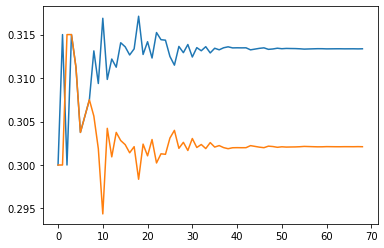

In [168]:
plt.plot(param1_list)
plt.plot(param2_list)
plt.show()

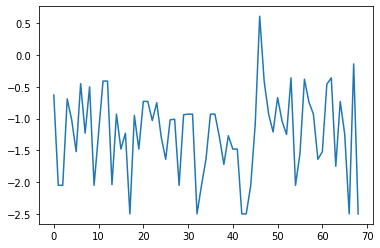

In [169]:
plt.plot(min_value_list)
plt.show()

Using Powell

In [178]:
shots=10
SV=False
Q=Q
param1_list=[]
param2_list=[]
min_value_list=[]
solution_list=[]
quantity_list=[]
params=[0.3,0.3]
res = minimize(func_bqm, params, bounds=((0.1, 0.8), (0.1, 0.8)), method='Powell', tol=0.01)
print(res)

   direc: array([[1., 0.],
       [0., 1.]])
     fun: -2.5000000000000004
 message: 'Optimization terminated successfully.'
    nfev: 35
     nit: 2
  status: 0
 success: True
       x: array([0.26858092, 0.58975883])


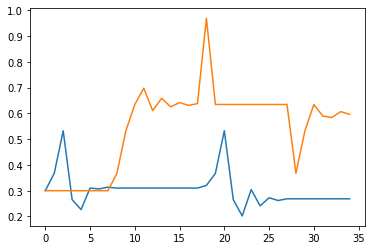

In [179]:
plt.plot(param1_list)
plt.plot(param2_list)
plt.show()

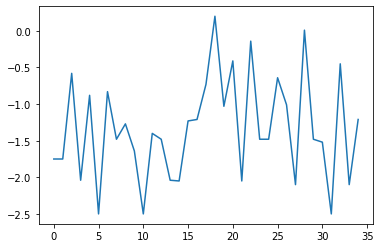

In [180]:
plt.plot(min_value_list)
plt.show()

### Multiple step parameter optimization in QAOA

In [181]:
#---------
param1=np.arange(0.1,0.8,0.15,dtype=float)
param2=np.arange(0.1,0.8,0.15,dtype=float)
print(param1)
print(param2)
#---------

[0.1  0.25 0.4  0.55 0.7 ]
[0.1  0.25 0.4  0.55 0.7 ]


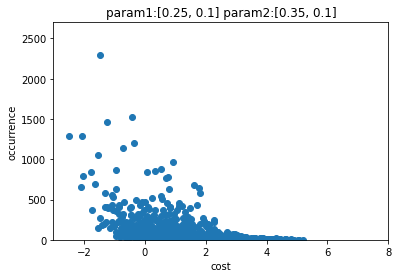

Parameters 0.1 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1283


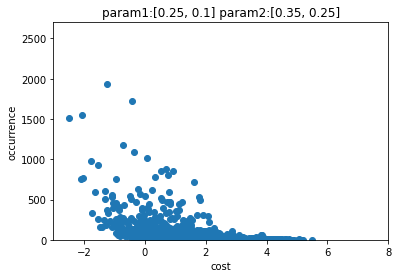

Parameters 0.1 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1517


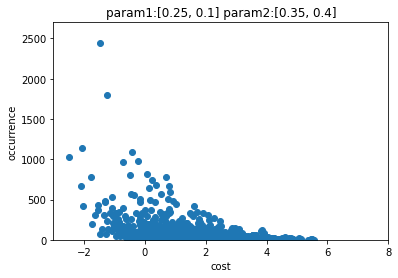

Parameters 0.1 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1027


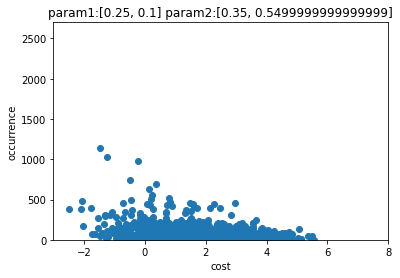

Parameters 0.1 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 388


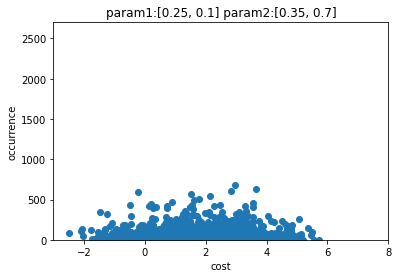

Parameters 0.1 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 81


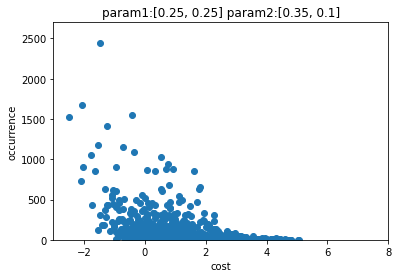

Parameters 0.25 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1530


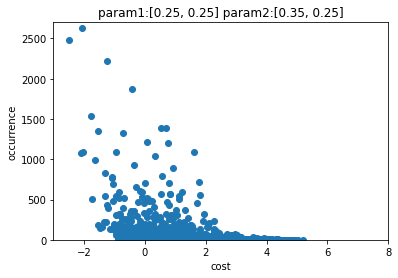

Parameters 0.25 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 2480


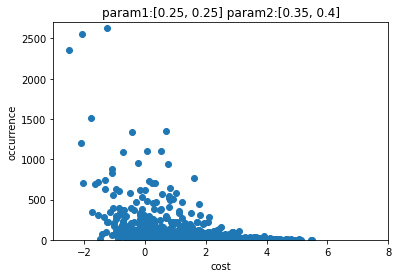

Parameters 0.25 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 2354


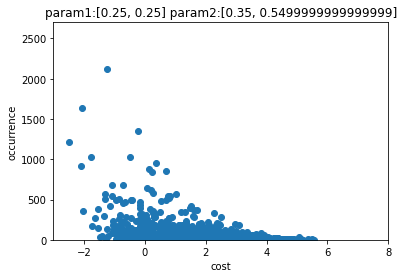

Parameters 0.25 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1219


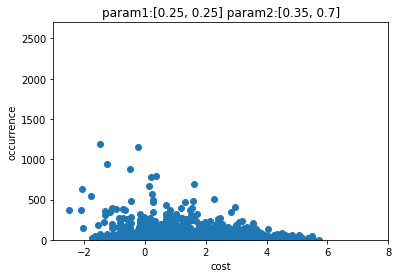

Parameters 0.25 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 375


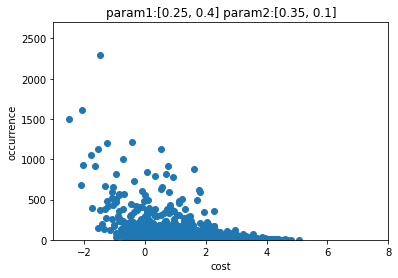

Parameters 0.4 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1495


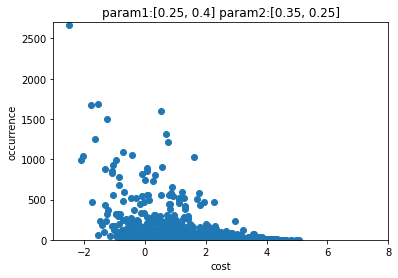

Parameters 0.4 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 2671


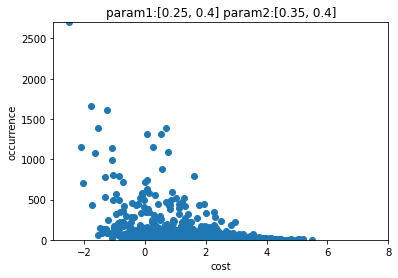

Parameters 0.4 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 2707


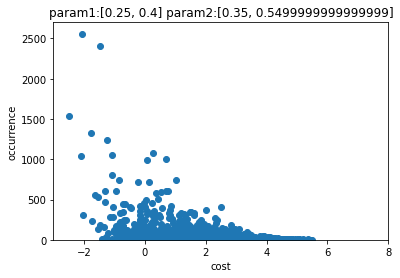

Parameters 0.4 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1538


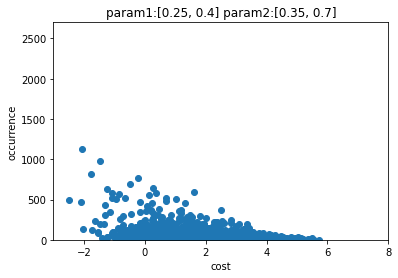

Parameters 0.4 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 492


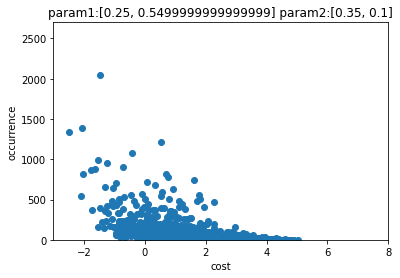

Parameters 0.5499999999999999 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1343


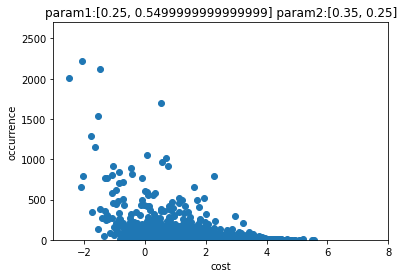

Parameters 0.5499999999999999 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 2006


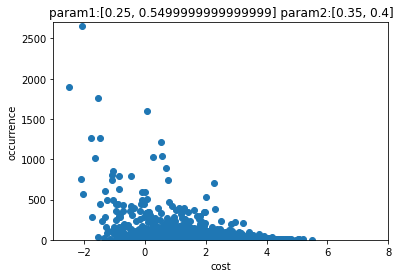

Parameters 0.5499999999999999 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1901


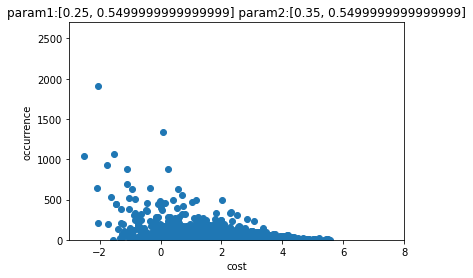

Parameters 0.5499999999999999 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1045


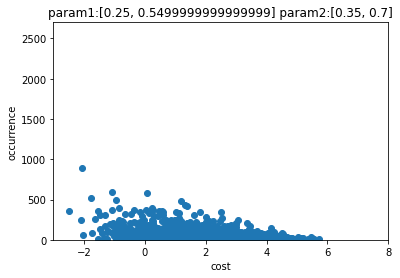

Parameters 0.5499999999999999 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 354


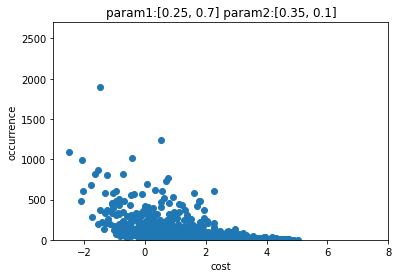

Parameters 0.7 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1095


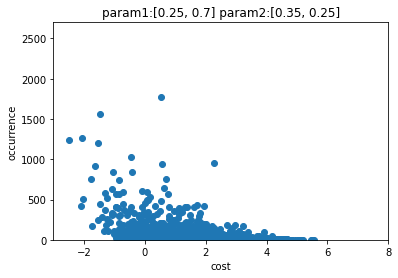

Parameters 0.7 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1242


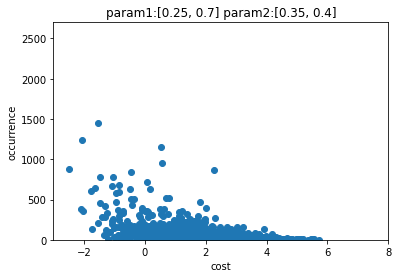

Parameters 0.7 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 885


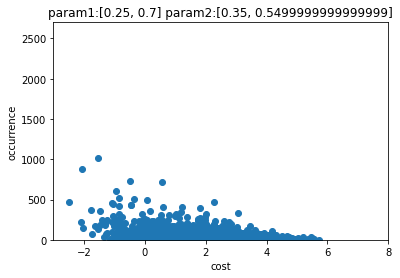

Parameters 0.7 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 470


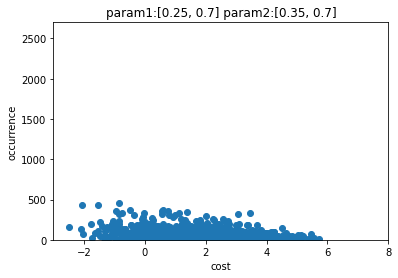

Parameters 0.7 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 161


In [188]:
for p1 in param1:
    for p2 in param2:
        solution,energy,quantity=optimize_bqm([0.25, p1], [0.35, p2], Q, 100000)
        print('Parameters', p1, p2, 'Solution:',solution, 'Energy:',energy, 'Qty Sampled',quantity)

## 2. Optimizing QUBO

### Optimizing 11x11 matrix

In [37]:
#Install scipy if not already installed
#!pip install scipy

In [37]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [38]:
file = open("IonQ_matrix.csv")
Q = np.loadtxt(file, delimiter=",")
print(Q)

[[ 1.3  -0.63 -0.34 -0.3   0.22  0.1   0.03 -0.5   0.28 -0.8  -0.1 ]
 [ 0.    0.51 -0.25  0.42  0.45  0.89  0.09 -0.8  -0.74 -0.68 -0.2 ]
 [ 0.    0.    0.84  0.03 -0.3   0.5  -0.22  0.7  -0.3   0.6   0.3 ]
 [ 0.    0.    0.    0.75  0.51 -0.2   0.25  0.3  -0.03  0.03  0.4 ]
 [ 0.    0.    0.    0.    0.27 -0.65 -0.4   0.2  -0.46  0.54 -0.2 ]
 [ 0.    0.    0.    0.    0.    0.15 -0.95  0.51  0.67 -0.22 -0.4 ]
 [ 0.    0.    0.    0.    0.    0.    0.35 -0.6   0.63  0.2   0.25]
 [ 0.    0.    0.    0.    0.    0.    0.    0.25 -0.81 -0.59 -0.4 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.5   0.01  0.3 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.6  -0.1 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.1 ]]


In [39]:
matrix_to_polynomial(Q)

+1.3x₀²+0.51x₁²+0.84x₂²+0.75x₃²+0.27x₄²+0.15x₅²+0.35x₆²+0.25x₇²+0.5x₈²+0.6x₉²+0.1x₁₀²-0.63x₀x₁-0.34x₀x₂-0.3x₀x₃+0.22x₀x₄+0.1x₀x₅+0.03x₀x₆-0.5x₀x₇+0.28x₀x₈-0.8x₀x₉-0.1x₀x₁₀-0.25x₁x₂+0.42x₁x₃+0.45x₁x₄+0.89x₁x₅+0.09x₁x₆-0.8x₁x₇-0.74x₁x₈-0.68x₁x₉-0.2x₁x₁₀+0.03x₂x₃-0.3x₂x₄+0.5x₂x₅-0.22x₂x₆+0.7x₂x₇-0.3x₂x₈+0.6x₂x₉+0.3x₂x₁₀+0.51x₃x₄-0.2x₃x₅+0.25x₃x₆+0.3x₃x₇-0.03x₃x₈+0.03x₃x₉+0.4x₃x₁₀-0.65x₄x₅-0.4x₄x₆+0.2x₄x₇-0.46x₄x₈+0.54x₄x₉-0.2x₄x₁₀-0.95x₅x₆+0.51x₅x₇+0.67x₅x₈-0.22x₅x₉-0.4x₅x₁₀-0.6x₆x₇+0.63x₆x₈+0.2x₆x₉+0.25x₆x₁₀-0.81x₇x₈-0.59x₇x₉-0.4x₇x₁₀+0.01x₈x₉+0.3x₈x₁₀-0.1x₉x₁₀


'+1.3x₀²+0.51x₁²+0.84x₂²+0.75x₃²+0.27x₄²+0.15x₅²+0.35x₆²+0.25x₇²+0.5x₈²+0.6x₉²+0.1x₁₀²-0.63x₀x₁-0.34x₀x₂-0.3x₀x₃+0.22x₀x₄+0.1x₀x₅+0.03x₀x₆-0.5x₀x₇+0.28x₀x₈-0.8x₀x₉-0.1x₀x₁₀-0.25x₁x₂+0.42x₁x₃+0.45x₁x₄+0.89x₁x₅+0.09x₁x₆-0.8x₁x₇-0.74x₁x₈-0.68x₁x₉-0.2x₁x₁₀+0.03x₂x₃-0.3x₂x₄+0.5x₂x₅-0.22x₂x₆+0.7x₂x₇-0.3x₂x₈+0.6x₂x₉+0.3x₂x₁₀+0.51x₃x₄-0.2x₃x₅+0.25x₃x₆+0.3x₃x₇-0.03x₃x₈+0.03x₃x₉+0.4x₃x₁₀-0.65x₄x₅-0.4x₄x₆+0.2x₄x₇-0.46x₄x₈+0.54x₄x₉-0.2x₄x₁₀-0.95x₅x₆+0.51x₅x₇+0.67x₅x₈-0.22x₅x₉-0.4x₅x₁₀-0.6x₆x₇+0.63x₆x₈+0.2x₆x₉+0.25x₆x₁₀-0.81x₇x₈-0.59x₇x₉-0.4x₇x₁₀+0.01x₈x₉+0.3x₈x₁₀-0.1x₉x₁₀'

### Evaluate ideal single set of parameters to find minimum

Using scipy optimizer

In [161]:
shots=10
SV=False
Q=Q
param1_list=[]
param2_list=[]
min_value_list=[]
solution_list=[]
quantity_list=[]
params=[0.3,0.3]
res = minimize(func_bqm, params, method='Nelder-Mead', tol=0.001)
#Nelder-Mead, Powell,COBYLA

In [162]:
print(res)

 final_simplex: (array([[0.3  , 0.315],
       [0.3  , 0.315],
       [0.3  , 0.315]]), array([-2.5 , -1.52, -0.87]))
           fun: -2.5000000000000004
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 401
           nit: 145
        status: 1
       success: False
             x: array([0.3  , 0.315])


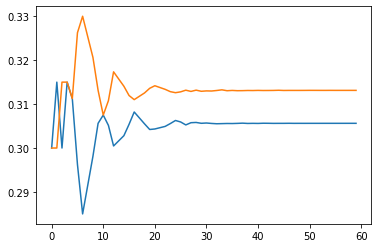

In [125]:
plt.plot(param1_list)
plt.plot(param2_list)
plt.show()

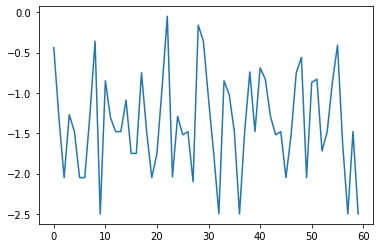

In [126]:
plt.plot(min_value_list)
plt.show()

In [127]:
for i in range(len(solution_list)):
    print(solution_list[i],quantity_list[i], min_value_list[i])

11010001011 1 -0.4399999999999997
01000001011 1 -1.31
01000001111 1 -2.0500000000000003
11000011010 1 -1.27
11001001111 1 -1.4799999999999995
01000001111 1 -2.0500000000000003
01000001111 1 -2.0500000000000003
11000011010 1 -1.27
00101110001 1 -0.3600000000000002
11000001111 1 -2.5000000000000004
11100001110 1 -0.8499999999999995
01000001011 1 -1.31
00001110001 1 -1.48
11001001111 1 -1.4799999999999995
01000001100 1 -1.09
01000001110 1 -1.7500000000000002
01000001110 1 -1.7500000000000002
01001001110 1 -0.7499999999999999
00001110001 1 -1.48
01000001111 1 -2.0500000000000003
01000001110 1 -1.7500000000000002
11010001111 1 -0.9299999999999996
00001001100 1 -0.050000000000000044
11000001011 1 -2.0399999999999996
01000001101 1 -1.2899999999999998
00001111001 1 -1.52
00001110001 1 -1.48
11000001110 1 -2.0999999999999996
01100001110 1 -0.16000000000000003
00101110001 1 -0.3600000000000002
01000011110 1 -1.0800000000000003
01000001110 1 -1.7500000000000002
11000001111 1 -2.5000000000000004
1

### STOP: Execution of Code below will result in Amazon Braket Charges

Using SV1

In [130]:
Qubits=len(Q)
max_val=2**Qubits
param=np.arange(0.1,0.5,0.1,dtype=float)
print(param)

[0.1 0.2 0.3 0.4]


0 1.3
1 0.51
2 0.84
3 0.75
4 0.27
5 0.15
6 0.35
7 0.25
8 0.5
9 0.6
10 0.1
T   : |0|1|    2     |    3     |    4     |         5         |         6         |             7             |              8              |                 9                  |                   10                   |                       11                       |                       12                        |                       13                       |                  14                   |                  15                  |              16              |             17              |        18         |        19         |   20   |   21    |  22   |
                                                                                                                                                                                                                                                                                                                                                              

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{1835: 1, 1096: 1, 1674: 1, 1355: 1, 466: 1, 629: 1, 1291: 1, 1507: 1, 452: 1, 1698: 1, 986: 1, 1300: 1, 113: 1, 1913: 1, 92: 1, 368: 1, 435: 1, 1867: 1, 837: 1, 900: 1, 849: 1, 165: 1, 1374: 1, 39: 1, 892: 1, 1934: 1, 739: 1, 760: 1, 1870: 1, 429: 1, 533: 1, 1149: 1, 191: 1, 2015: 1, 926: 1, 1210: 2, 1743: 1, 1463: 1, 520: 1, 1908: 1, 134: 1, 547: 1, 1461: 1, 1412: 1, 1440: 1, 41: 2, 509: 1, 1940: 1, 28: 1, 337: 1, 186: 1, 860: 1, 1218: 1, 1547: 2, 444: 1, 764: 1, 1067: 1, 1820: 1, 1631: 1, 1807: 1, 756: 1, 1854: 1, 98: 1, 1215: 1, 790: 1, 673: 1, 1933: 1, 3: 1, 831: 1, 500: 1, 1548: 1, 1764: 1, 25: 1, 864: 1, 1602: 1, 974: 1, 499: 1, 889: 1, 227: 1, 2039: 1, 1734: 1, 11: 1, 594: 1, 608: 1, 1139: 1, 433: 1, 147: 1, 650: 1, 323: 1, 270: 1,

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{1142: 1, 444: 1, 1461: 1, 1744: 2, 747: 1, 1934: 1, 368: 1, 1219: 1, 1798: 1, 242: 2, 89: 1, 1806: 1, 337: 1, 1908: 1, 1690: 1, 153: 1, 250: 1, 1413: 1, 892: 1, 1252: 1, 2046: 1, 1633: 1, 9: 1, 1153: 1, 144: 1, 498: 1, 600: 1, 333: 1, 1651: 1, 671: 1, 33: 1, 1281: 1, 472: 1, 389: 1, 39: 1, 228: 1, 1928: 1, 1585: 1, 1603: 1, 1014: 1, 1804: 1, 1527: 1, 1713: 1, 1157: 1, 915: 1, 914: 1, 701: 1, 1080: 1, 1888: 1, 424: 1, 442: 1, 1338: 1, 1669: 1, 1257: 1, 1539: 2, 954: 1, 843: 1, 48: 1, 71: 1, 705: 1, 264: 1, 67: 1, 792: 1, 884: 1, 832: 1, 580: 1, 1659: 1, 162: 1, 145: 1, 636: 1, 940: 1, 897: 1, 150: 1, 1790: 1, 2045: 1, 114: 1, 142: 1, 376: 1, 517: 1, 1151: 1, 1288: 1, 340: 1, 1392: 1, 906: 1, 1870: 1, 1379: 1, 841: 1, 1401: 1, 1950: 1, 1839

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{542: 1, 1322: 1, 1139: 1, 980: 1, 313: 1, 1298: 1, 1200: 1, 128: 1, 1594: 1, 798: 1, 906: 1, 335: 1, 476: 1, 678: 1, 81: 1, 1595: 1, 113: 1, 109: 1, 1763: 1, 1409: 1, 1581: 1, 1743: 1, 1591: 1, 372: 1, 36: 1, 856: 1, 1320: 1, 1706: 1, 47: 1, 647: 1, 1132: 1, 687: 1, 163: 1, 1871: 1, 579: 1, 1567: 1, 1948: 1, 999: 1, 168: 1, 193: 1, 498: 1, 101: 1, 281: 1, 1190: 1, 1379: 1, 497: 1, 1915: 1, 500: 1, 123: 1, 117: 1, 543: 1, 1150: 1, 882: 2, 501: 1, 134: 1, 1718: 1, 1502: 1, 1156: 1, 516: 1, 646: 2, 1785: 1, 594: 1, 133: 1, 385: 1, 368: 1, 176: 1, 1823: 2, 932: 1, 1539: 1, 1050: 1, 1919: 1, 1905: 1, 8: 1, 305: 1, 558: 1, 11: 1, 828: 1, 1631: 1, 58: 2, 526: 1, 576: 1, 341: 1, 785: 1, 1835: 1, 2023: 1, 345: 1, 135: 1, 762: 1, 347: 1, 226: 1, 55

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{654: 1, 70: 2, 143: 1, 56: 1, 1647: 1, 581: 1, 1131: 1, 596: 1, 1024: 1, 916: 1, 1067: 1, 65: 1, 0: 1, 1555: 1, 401: 2, 945: 1, 597: 1, 1187: 1, 187: 1, 1097: 1, 1726: 1, 501: 1, 733: 1, 141: 1, 176: 1, 344: 1, 895: 1, 1393: 1, 887: 1, 161: 1, 637: 1, 522: 1, 1670: 1, 155: 1, 102: 1, 1891: 1, 17: 1, 484: 1, 80: 1, 1953: 1, 1446: 1, 160: 1, 1544: 1, 617: 1, 99: 1, 1059: 1, 436: 1, 852: 1, 868: 1, 1383: 1, 1113: 1, 369: 1, 1710: 1, 697: 1, 1162: 1, 324: 1, 844: 1, 1702: 1, 481: 1, 1880: 1, 1564: 1, 50: 1, 590: 1, 998: 1, 1468: 1, 1948: 1, 508: 1, 1551: 1, 129: 1, 944: 1, 469: 1, 1399: 1, 889: 1, 1595: 1, 385: 1, 2043: 1, 882: 1, 1659: 1, 505: 1, 999: 1, 640: 1, 1215: 1, 156: 1, 1547: 1, 1866: 1, 759: 1, 729: 1, 770: 1, 386: 1, 1266: 1, 34: 

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{361: 1, 1542: 2, 143: 1, 1737: 1, 844: 1, 720: 1, 1138: 1, 496: 2, 1723: 1, 1356: 1, 1253: 1, 188: 1, 1005: 1, 82: 1, 1233: 1, 1870: 1, 1883: 1, 1556: 1, 775: 1, 253: 1, 1518: 1, 763: 1, 627: 1, 209: 1, 256: 1, 1449: 1, 1647: 1, 1231: 1, 513: 1, 1112: 1, 1436: 1, 1605: 1, 2045: 1, 25: 1, 845: 1, 1195: 1, 249: 1, 1678: 1, 936: 1, 342: 1, 1577: 1, 325: 2, 1158: 1, 27: 1, 53: 1, 1398: 1, 780: 1, 1885: 1, 802: 1, 1672: 1, 1598: 1, 755: 1, 1989: 1, 242: 1, 596: 1, 1245: 1, 1741: 1, 1222: 1, 944: 1, 107: 1, 1170: 1, 1886: 1, 1032: 1, 1996: 1, 910: 1, 117: 1, 244: 1, 1620: 1, 603: 1, 1474: 1, 887: 1, 1529: 1, 1998: 1, 542: 1, 1139: 1, 1017: 1, 536: 1, 383: 1, 1476: 1, 1137: 1, 1969: 1, 922: 1, 1932: 1, 100: 1, 704: 1, 308: 1, 1184: 1, 685: 1, 11

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{373: 1, 115: 1, 120: 2, 898: 1, 563: 1, 58: 2, 1252: 1, 515: 1, 369: 1, 1679: 1, 1547: 3, 448: 2, 117: 1, 1671: 1, 944: 1, 1925: 1, 161: 2, 911: 1, 1983: 1, 782: 2, 1522: 1, 1807: 1, 224: 1, 639: 1, 949: 1, 370: 2, 1266: 1, 333: 1, 324: 1, 1560: 1, 1025: 1, 1118: 1, 1933: 1, 1057: 1, 1666: 1, 1435: 1, 574: 1, 453: 2, 836: 1, 2000: 1, 166: 1, 605: 1, 409: 1, 15: 2, 315: 1, 1159: 1, 380: 1, 646: 1, 1843: 1, 243: 1, 1442: 1, 240: 1, 1416: 1, 355: 1, 1374: 1, 307: 1, 1231: 1, 108: 1, 1032: 1, 116: 1, 377: 1, 845: 1, 175: 1, 304: 1, 1694: 1, 1702: 1, 1707: 1, 547: 1, 523: 1, 133: 1, 368: 1, 269: 1, 388: 1, 575: 1, 34: 1, 1344: 1, 1436: 1, 1695: 1, 77: 1, 311: 1, 570: 1, 1548: 1, 481: 1, 169: 1, 140: 1, 1649: 1, 1139: 1, 967: 1, 320: 1, 228: 1}

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{1950: 1, 1164: 1, 125: 1, 368: 1, 632: 1, 675: 1, 0: 1, 526: 2, 96: 1, 1092: 1, 1402: 1, 1442: 1, 64: 1, 1562: 1, 256: 1, 1828: 1, 1407: 1, 1887: 1, 1565: 1, 516: 1, 188: 1, 113: 1, 348: 1, 1394: 1, 114: 1, 702: 1, 1679: 1, 1651: 1, 740: 1, 591: 1, 603: 1, 304: 1, 1690: 1, 623: 1, 1667: 1, 1185: 1, 241: 2, 1275: 1, 1457: 1, 501: 1, 324: 1, 1209: 1, 1336: 1, 1281: 1, 701: 1, 973: 1, 1868: 1, 895: 1, 141: 1, 604: 1, 803: 1, 652: 1, 521: 1, 1289: 1, 1720: 1, 924: 1, 496: 1, 1934: 1, 111: 1, 523: 1, 115: 1, 1976: 1, 1926: 1, 646: 2, 121: 1, 845: 1, 1195: 2, 2045: 1, 1594: 1, 1162: 1, 1806: 1, 76: 1, 774: 1, 644: 1, 733: 1, 894: 1, 1563: 1, 94: 1, 1935: 1, 613: 1, 1595: 1, 1894: 1, 1807: 1, 32: 1, 435: 1, 1803: 1, 1444: 1, 432: 1, 1170: 1, 196

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{1875: 1, 1678: 1, 185: 1, 900: 1, 1919: 3, 432: 1, 178: 1, 113: 1, 131: 2, 112: 1, 897: 2, 1392: 1, 484: 1, 1763: 1, 1435: 1, 1880: 1, 160: 1, 1473: 1, 655: 1, 254: 1, 1663: 1, 369: 1, 523: 1, 32: 2, 340: 1, 751: 1, 1195: 1, 516: 2, 1057: 1, 124: 1, 468: 1, 34: 1, 230: 1, 868: 1, 144: 1, 88: 1, 829: 1, 1579: 1, 361: 1, 1821: 1, 1166: 1, 224: 1, 497: 1, 1817: 1, 1184: 1, 349: 1, 240: 1, 546: 1, 775: 1, 231: 1, 1850: 1, 163: 2, 623: 1, 1869: 2, 123: 1, 461: 1, 1211: 1, 26: 1, 513: 1, 372: 1, 1876: 1, 59: 2, 193: 1, 858: 1, 1460: 1, 97: 1, 122: 1, 533: 1, 1647: 1, 1251: 1, 9: 1, 644: 1, 130: 1, 289: 1, 1707: 1, 1083: 1, 772: 1, 1146: 1, 2034: 1, 1804: 1, 574: 1, 554: 1, 589: 1, 768: 1, 573: 1, 385: 1, 1676: 1, 176: 1, 605: 1, 33: 1, 1265: 1}

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{628: 2, 408: 1, 1162: 1, 1720: 1, 1151: 1, 440: 1, 524: 3, 1660: 1, 1347: 1, 1263: 1, 955: 1, 369: 1, 51: 1, 114: 1, 1577: 1, 1932: 1, 1465: 1, 129: 1, 1536: 1, 834: 1, 31: 1, 33: 1, 1081: 1, 1199: 1, 1395: 1, 635: 1, 78: 1, 1225: 1, 327: 1, 176: 1, 1274: 1, 1668: 1, 1650: 1, 1402: 1, 479: 1, 1389: 1, 1738: 1, 355: 1, 86: 1, 772: 1, 741: 1, 1692: 1, 1110: 1, 314: 1, 1198: 1, 69: 1, 778: 1, 668: 1, 482: 1, 1877: 1, 663: 1, 1643: 1, 330: 1, 536: 1, 76: 1, 1508: 1, 897: 1, 459: 1, 418: 1, 10: 1, 274: 1, 1530: 1, 792: 1, 848: 1, 117: 1, 1966: 1, 828: 1, 451: 1, 388: 1, 185: 1, 1146: 1, 2043: 1, 964: 1, 1351: 1, 1690: 1, 1565: 1, 238: 1, 822: 1, 1254: 1, 324: 1, 419: 1, 1330: 1, 1074: 1, 1960: 1, 526: 1, 550: 1, 673: 1, 1927: 1, 1505: 1, 625: 

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{1392: 1, 538: 1, 920: 1, 82: 1, 1915: 1, 563: 1, 606: 1, 1534: 1, 844: 1, 19: 1, 562: 1, 772: 1, 453: 1, 517: 1, 1630: 1, 264: 1, 908: 1, 1264: 1, 1818: 2, 141: 2, 10: 1, 130: 1, 924: 1, 1275: 1, 1185: 1, 572: 1, 256: 1, 816: 1, 1412: 1, 116: 1, 160: 1, 1956: 1, 115: 2, 1137: 1, 176: 1, 570: 1, 2014: 1, 348: 1, 1633: 1, 1699: 1, 625: 1, 326: 1, 527: 1, 208: 1, 2006: 1, 68: 1, 229: 1, 500: 1, 60: 1, 785: 1, 537: 1, 466: 1, 238: 1, 1240: 1, 99: 1, 1563: 1, 1819: 1, 1822: 1, 617: 1, 281: 1, 639: 1, 1813: 1, 56: 1, 719: 1, 129: 1, 1690: 1, 1532: 1, 1138: 1, 1469: 1, 1155: 1, 515: 1, 324: 1, 260: 1, 1650: 1, 97: 1, 624: 1, 386: 1, 1930: 1, 1775: 1, 477: 1, 544: 1, 1820: 1, 105: 1, 1403: 1, 540: 1, 733: 1, 1523: 1, 102: 1, 1595: 1, 644: 1, 900:

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{1123: 1, 653: 1, 1935: 1, 177: 1, 239: 1, 628: 1, 153: 1, 77: 1, 581: 1, 783: 1, 1723: 1, 1551: 1, 50: 1, 526: 1, 559: 1, 1818: 1, 1532: 1, 655: 2, 989: 1, 121: 1, 484: 1, 1508: 1, 241: 1, 1915: 1, 1595: 1, 816: 1, 539: 1, 909: 1, 369: 1, 257: 1, 924: 1, 897: 1, 162: 1, 480: 1, 1795: 1, 485: 1, 348: 1, 1615: 1, 1570: 1, 1971: 1, 252: 1, 1187: 1, 964: 1, 452: 1, 161: 1, 65: 1, 1675: 1, 163: 1, 57: 1, 185: 1, 114: 2, 453: 1, 481: 1, 1528: 1, 830: 1, 525: 2, 601: 1, 340: 1, 125: 1, 1881: 1, 1566: 1, 587: 1, 355: 1, 517: 1, 127: 1, 1699: 1, 384: 1, 178: 1, 645: 1, 92: 2, 97: 1, 1710: 1, 111: 1, 583: 1, 1546: 1, 73: 1, 1841: 1, 51: 1, 1456: 1, 353: 1, 332: 1, 1667: 1, 1186: 1, 113: 1, 1703: 1, 1160: 1, 1211: 1, 176: 1, 837: 1, 833: 1, 254: 1, 

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{59: 1, 123: 2, 769: 1, 1918: 1, 160: 2, 324: 1, 525: 2, 1996: 1, 1345: 1, 526: 2, 1798: 1, 121: 4, 1862: 1, 320: 1, 1410: 1, 161: 1, 369: 1, 25: 1, 527: 1, 1273: 1, 240: 2, 1521: 1, 112: 1, 1551: 1, 646: 1, 500: 2, 861: 1, 97: 1, 115: 1, 186: 1, 1579: 1, 1: 1, 671: 1, 538: 1, 1934: 2, 179: 1, 571: 1, 228: 1, 902: 1, 1560: 1, 1631: 1, 113: 1, 3: 1, 1571: 1, 1403: 1, 114: 2, 689: 1, 432: 1, 853: 1, 1659: 1, 756: 1, 356: 1, 1505: 1, 1969: 1, 51: 1, 1991: 1, 368: 1, 852: 1, 14: 1, 162: 1, 1909: 1, 1504: 1, 772: 1, 1203: 1, 68: 1, 1275: 1, 845: 1, 836: 3, 43: 1, 1578: 1, 518: 1, 272: 1, 175: 1, 120: 1, 129: 1, 1222: 1, 50: 1, 256: 1, 825: 1, 1306: 1, 1678: 1, 484: 1, 677: 1, 589: 1, 816: 1, 523: 1, 1392: 1}
0 1.3
1 0.51
2 0.84
3 0.75
4 0.27
5 

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{370: 1, 134: 1, 1199: 1, 497: 2, 260: 1, 379: 1, 35: 1, 1943: 1, 710: 1, 498: 1, 367: 1, 1127: 1, 1264: 1, 1942: 1, 2027: 1, 1966: 1, 1965: 1, 496: 1, 994: 1, 1509: 1, 1412: 1, 1886: 1, 1051: 1, 1021: 1, 1996: 2, 284: 1, 1812: 1, 1465: 1, 215: 1, 1722: 1, 1194: 1, 139: 1, 1205: 1, 232: 1, 484: 1, 610: 1, 555: 1, 353: 1, 1371: 1, 1392: 1, 1988: 1, 752: 1, 1806: 1, 574: 2, 1879: 1, 256: 1, 224: 1, 1184: 1, 1410: 1, 1710: 1, 1114: 1, 1868: 1, 1887: 1, 588: 1, 1213: 1, 171: 1, 338: 1, 1201: 1, 1765: 1, 1340: 1, 45: 1, 1674: 1, 1697: 1, 620: 1, 509: 1, 997: 1, 1405: 1, 94: 1, 813: 1, 1543: 2, 277: 1, 687: 1, 1512: 1, 638: 1, 1667: 1, 587: 1, 1267: 1, 1102: 1, 568: 1, 92: 1, 894: 1, 1816: 1, 1752: 1, 1210: 1, 652: 1, 259: 1, 780: 1, 598: 1, 128

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{161: 1, 1935: 1, 1702: 1, 1860: 1, 332: 1, 1210: 1, 1969: 1, 162: 1, 1127: 1, 121: 2, 237: 1, 1599: 1, 345: 1, 1125: 1, 997: 1, 1393: 1, 1456: 1, 1131: 1, 1694: 1, 42: 1, 388: 2, 1476: 1, 604: 1, 385: 1, 376: 2, 637: 2, 1667: 1, 1707: 1, 68: 2, 1934: 2, 197: 1, 249: 1, 353: 2, 605: 1, 1594: 1, 902: 1, 607: 1, 526: 2, 1709: 1, 1689: 1, 976: 1, 165: 1, 425: 1, 651: 1, 127: 1, 527: 1, 140: 1, 880: 1, 1798: 1, 35: 1, 504: 1, 1628: 1, 1659: 1, 1033: 1, 675: 1, 1919: 1, 274: 1, 231: 1, 793: 1, 115: 1, 116: 1, 0: 1, 1529: 1, 175: 1, 230: 1, 924: 1, 113: 1, 49: 1, 1948: 1, 895: 1, 546: 1, 12: 1, 336: 1, 1627: 1, 83: 1, 786: 1, 636: 1, 185: 1, 243: 1, 1583: 2, 812: 1, 988: 1, 1807: 1, 1855: 1, 281: 1, 244: 1, 632: 1, 1958: 1, 1932: 1, 696: 1, 814:

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{1862: 1, 101: 2, 486: 1, 449: 1, 948: 1, 1932: 1, 1: 1, 686: 1, 793: 1, 108: 1, 77: 1, 35: 1, 368: 3, 1202: 2, 739: 1, 121: 3, 1456: 1, 396: 1, 465: 1, 1709: 1, 476: 1, 1195: 1, 1807: 1, 524: 2, 57: 1, 653: 1, 1039: 1, 0: 1, 369: 2, 1805: 1, 828: 1, 345: 1, 83: 1, 2047: 1, 79: 1, 1924: 1, 1872: 1, 64: 1, 58: 1, 1547: 1, 92: 2, 337: 2, 845: 1, 1185: 1, 861: 1, 385: 1, 1377: 1, 2019: 1, 163: 1, 136: 1, 116: 1, 1190: 1, 113: 1, 772: 1, 589: 1, 1121: 1, 1627: 1, 1144: 1, 1462: 1, 33: 1, 1230: 1, 1083: 1, 146: 1, 388: 1, 526: 1, 688: 1, 1679: 1, 393: 1, 289: 1, 361: 1, 124: 1, 606: 1, 1722: 1, 123: 1, 654: 1, 775: 1, 1211: 1, 191: 1, 836: 1, 1794: 1, 917: 1, 1869: 1, 186: 1, 1992: 1, 1936: 1, 1278: 1, 769: 1, 1550: 1, 99: 1, 1595: 1}
0 1.3
1 0

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{1955: 1, 1273: 2, 369: 1, 1869: 2, 537: 1, 384: 1, 1171: 1, 1008: 1, 197: 1, 176: 1, 1547: 2, 860: 1, 524: 1, 1392: 1, 121: 3, 140: 1, 880: 1, 1595: 1, 368: 1, 639: 1, 653: 1, 1195: 1, 33: 1, 388: 2, 515: 1, 484: 1, 224: 1, 184: 2, 596: 1, 1659: 2, 132: 2, 517: 1, 696: 1, 1550: 1, 1822: 1, 1551: 3, 161: 1, 68: 1, 1164: 1, 780: 1, 113: 1, 19: 1, 160: 1, 505: 1, 228: 1, 1537: 1, 527: 1, 1739: 1, 93: 1, 357: 1, 52: 1, 238: 1, 924: 1, 812: 1, 49: 1, 101: 1, 1149: 1, 127: 1, 1678: 1, 1125: 1, 1: 1, 523: 1, 539: 1, 1806: 2, 225: 1, 1630: 1, 26: 1, 571: 1, 1820: 1, 512: 1, 116: 1, 2: 1, 124: 1, 0: 1, 628: 1, 844: 1, 315: 1, 1818: 1, 884: 1, 102: 1, 496: 1, 128: 1, 1147: 1, 540: 1, 422: 1, 1926: 1, 654: 1, 1121: 1}
0.1 0.4 -2.5000000000000004


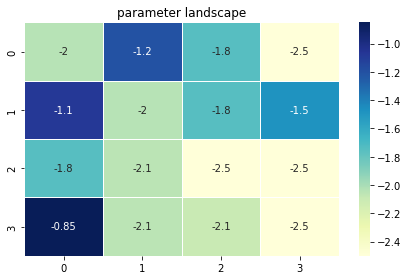

In [131]:
ideal_param1, ideal_param2, lowest_energy=param_optimizer_device(param, param, Q, 100,'SV1')
print(ideal_param1, ideal_param2, lowest_energy)

Using TN1

0 1.3
1 0.51
2 0.84
3 0.75
4 0.27
5 0.15
6 0.35
7 0.25
8 0.5
9 0.6
10 0.1
T   : |0|1|    2     |    3     |    4     |         5         |         6         |             7             |              8              |                 9                  |                   10                   |                       11                       |                       12                        |                       13                       |                  14                   |                  15                  |              16              |             17              |        18         |        19         |   20   |   21    |  22   |
                                                                                                                                                                                                                                                                                                                                                              

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{436: 1, 321: 1, 1292: 1, 1525: 1, 101: 1, 332: 1, 1950: 1, 1321: 1, 987: 1, 1621: 1, 533: 1, 694: 1, 286: 1, 1202: 1, 1408: 1, 613: 1, 481: 1, 705: 1, 175: 1, 318: 1, 839: 1, 903: 1, 394: 1, 1981: 1, 1442: 1, 669: 1, 1987: 1, 2005: 1, 870: 1, 780: 1, 642: 1, 192: 1, 1919: 1, 1958: 1, 858: 1, 35: 1, 375: 1, 1254: 1, 783: 1, 1834: 1, 535: 1, 222: 1, 449: 1, 1056: 1, 846: 1, 1288: 1, 324: 1, 1122: 1, 1658: 1, 1591: 1, 634: 1, 1791: 1, 1793: 1, 453: 1, 1012: 1, 392: 1, 579: 1, 2011: 1, 134: 1, 600: 1, 1182: 1, 410: 1, 1893: 1, 1752: 1, 655: 1, 1956: 1, 954: 1, 1550: 1, 212: 1, 1477: 1, 686: 1, 991: 1, 1116: 1, 1427: 1, 1377: 1, 438: 1, 915: 1, 226: 1, 1170: 1, 2018: 1, 691: 1, 28: 1, 1392: 1, 220: 1, 702: 1, 151: 1, 1599: 1, 1618: 1, 675: 1, 

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{567: 1, 273: 1, 1674: 1, 1338: 1, 1288: 1, 386: 2, 46: 1, 1195: 1, 1427: 1, 1795: 1, 1657: 1, 257: 1, 127: 1, 251: 1, 340: 1, 1524: 1, 99: 1, 398: 1, 782: 1, 822: 1, 1356: 1, 1244: 1, 1280: 1, 1073: 2, 925: 1, 537: 1, 666: 1, 1654: 1, 253: 1, 1986: 1, 752: 1, 112: 1, 852: 1, 1080: 1, 236: 1, 444: 1, 1403: 1, 1329: 1, 1178: 1, 485: 1, 125: 1, 1586: 1, 428: 1, 94: 1, 141: 1, 67: 1, 598: 1, 77: 1, 1777: 1, 1661: 1, 1273: 1, 1794: 2, 1678: 1, 921: 1, 1521: 1, 672: 1, 712: 1, 636: 1, 1326: 1, 862: 1, 123: 1, 510: 1, 219: 1, 1516: 1, 202: 1, 1264: 1, 1819: 1, 2032: 1, 1480: 1, 526: 1, 1496: 1, 189: 2, 272: 1, 451: 1, 1131: 1, 59: 1, 996: 1, 1806: 1, 615: 1, 750: 1, 1820: 1, 255: 1, 379: 1, 124: 1, 107: 1, 1233: 1, 118: 1, 1572: 1, 1919: 1, 1227

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{252: 1, 245: 1, 500: 1, 885: 1, 1579: 2, 988: 1, 968: 1, 550: 1, 1081: 2, 359: 1, 609: 1, 140: 1, 1779: 1, 780: 2, 973: 1, 327: 1, 1999: 1, 1614: 1, 515: 1, 724: 1, 1886: 1, 788: 1, 481: 1, 32: 1, 1796: 1, 775: 1, 1742: 1, 1275: 1, 623: 1, 84: 1, 620: 1, 497: 1, 1111: 1, 1547: 1, 522: 1, 1822: 1, 125: 1, 225: 1, 537: 1, 1161: 1, 1986: 1, 753: 1, 363: 1, 166: 1, 1271: 1, 1476: 1, 1564: 1, 442: 1, 1969: 1, 185: 1, 374: 1, 56: 1, 539: 1, 1078: 1, 1376: 1, 1488: 1, 113: 1, 844: 1, 76: 1, 1206: 1, 1426: 1, 1359: 1, 1280: 1, 1823: 1, 325: 1, 322: 1, 523: 1, 129: 1, 356: 1, 176: 1, 326: 1, 1504: 1, 48: 1, 142: 1, 1539: 1, 781: 1, 1321: 1, 1825: 1, 144: 1, 1595: 1, 660: 1, 1227: 1, 15: 1, 611: 1, 435: 1, 1785: 1, 308: 1, 37: 1, 1805: 1, 240: 1, 1

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{179: 1, 1870: 1, 59: 1, 843: 1, 1033: 1, 404: 2, 1934: 2, 178: 1, 1478: 1, 1818: 1, 145: 1, 1684: 1, 1259: 1, 645: 1, 1222: 1, 1186: 1, 1536: 1, 980: 1, 357: 1, 73: 1, 1476: 1, 1804: 1, 603: 1, 238: 1, 794: 2, 732: 1, 609: 1, 818: 1, 1677: 1, 94: 1, 945: 1, 793: 1, 31: 1, 385: 1, 1932: 1, 1116: 1, 1089: 1, 1694: 1, 0: 1, 186: 2, 624: 1, 241: 1, 247: 1, 1342: 1, 32: 1, 1611: 1, 369: 1, 764: 1, 1148: 1, 1096: 1, 1412: 1, 1456: 1, 1876: 1, 1860: 1, 79: 1, 1300: 1, 1884: 1, 1571: 1, 587: 1, 1036: 1, 1348: 1, 175: 1, 1670: 2, 432: 1, 379: 1, 1650: 1, 361: 1, 834: 1, 1158: 1, 1543: 1, 132: 1, 1845: 1, 1663: 1, 1796: 1, 860: 1, 772: 1, 1869: 1, 1409: 1, 62: 1, 1565: 1, 1679: 1, 2025: 1, 1272: 1, 653: 1, 1164: 1, 51: 1, 1668: 1, 1798: 1, 1137: 1,

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{844: 1, 368: 1, 857: 1, 1887: 1, 113: 1, 767: 1, 1478: 1, 1396: 1, 1313: 1, 1422: 3, 1179: 1, 103: 1, 54: 1, 795: 1, 99: 2, 1529: 1, 692: 1, 998: 1, 894: 1, 742: 1, 1321: 1, 621: 1, 700: 1, 832: 1, 375: 1, 1176: 1, 1136: 1, 282: 1, 1700: 1, 96: 1, 901: 1, 1388: 1, 79: 1, 187: 1, 782: 1, 1575: 1, 1661: 1, 1572: 1, 540: 1, 1624: 1, 228: 1, 210: 1, 1099: 1, 522: 1, 695: 1, 216: 1, 369: 1, 121: 1, 1243: 1, 1287: 1, 304: 1, 111: 1, 878: 1, 398: 1, 1382: 1, 1993: 1, 500: 1, 1696: 1, 1378: 1, 1165: 1, 1507: 1, 204: 1, 1996: 1, 507: 1, 1121: 1, 1275: 1, 336: 1, 1250: 1, 285: 1, 706: 1, 152: 1, 229: 1, 1083: 1, 2015: 1, 1819: 1, 237: 1, 1249: 1, 1200: 1, 1283: 1, 974: 1, 1: 1, 1570: 1, 959: 1, 1307: 1, 1970: 1, 964: 1, 1868: 1, 1324: 1, 371: 1, 57

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{353: 2, 123: 1, 1915: 1, 28: 1, 880: 1, 1809: 1, 1657: 1, 1679: 1, 901: 1, 368: 2, 964: 2, 1187: 1, 1424: 1, 1946: 1, 536: 1, 925: 1, 916: 1, 1267: 1, 1983: 1, 781: 1, 1393: 1, 502: 1, 1027: 1, 481: 1, 606: 1, 526: 2, 569: 1, 1476: 1, 1135: 1, 1817: 1, 1217: 1, 784: 1, 240: 1, 740: 1, 1162: 1, 780: 1, 1625: 1, 1117: 1, 81: 1, 541: 1, 480: 1, 1521: 1, 1870: 1, 845: 1, 1415: 1, 515: 1, 966: 1, 1699: 1, 538: 1, 645: 1, 129: 1, 1220: 1, 1667: 1, 768: 1, 785: 1, 1300: 1, 1012: 1, 627: 1, 337: 1, 1180: 1, 1970: 1, 1339: 1, 631: 1, 112: 1, 372: 1, 544: 1, 1551: 1, 1395: 1, 186: 1, 225: 1, 1690: 1, 24: 1, 1921: 1, 1794: 1, 134: 1, 633: 1, 900: 1, 978: 1, 477: 1, 15: 1, 711: 1, 975: 1, 114: 1, 493: 1, 433: 1, 260: 1, 1528: 1, 1599: 1, 772: 1, 762:

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{1595: 1, 1629: 1, 1071: 1, 508: 2, 1675: 1, 1420: 1, 1058: 1, 114: 1, 1696: 1, 142: 1, 1988: 1, 95: 1, 1547: 1, 1615: 1, 959: 1, 1509: 1, 1551: 1, 1726: 1, 604: 1, 64: 1, 435: 1, 4: 2, 601: 1, 1210: 1, 171: 1, 1082: 1, 48: 1, 226: 1, 606: 1, 1886: 1, 240: 2, 376: 1, 326: 1, 130: 1, 96: 1, 3: 1, 771: 1, 2038: 1, 861: 1, 581: 1, 400: 2, 1933: 1, 639: 1, 1823: 1, 1670: 2, 1392: 1, 1421: 1, 964: 1, 106: 1, 1801: 1, 555: 1, 537: 1, 152: 1, 1523: 1, 589: 1, 522: 1, 78: 1, 563: 1, 1400: 1, 836: 1, 69: 1, 1150: 1, 1919: 1, 1934: 1, 73: 1, 1203: 1, 1520: 1, 432: 1, 544: 1, 1870: 1, 324: 1, 434: 1, 497: 1, 863: 1, 542: 1, 607: 1, 224: 1, 1694: 1, 13: 1, 1887: 1, 257: 1, 246: 1, 51: 1, 1253: 1, 256: 1, 2019: 1, 1476: 1, 132: 1, 14: 1, 241: 1, 1609: 

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{50: 1, 836: 2, 1996: 1, 109: 1, 1625: 1, 49: 1, 448: 2, 145: 1, 230: 1, 177: 2, 1138: 1, 1920: 2, 1456: 1, 1344: 1, 241: 1, 272: 2, 1393: 1, 176: 1, 525: 1, 372: 1, 46: 1, 100: 1, 652: 1, 1818: 1, 543: 1, 65: 1, 368: 1, 1798: 1, 348: 1, 1934: 1, 1507: 1, 34: 1, 452: 1, 254: 1, 1210: 1, 134: 1, 1921: 1, 384: 1, 1767: 1, 1887: 1, 786: 1, 132: 1, 204: 2, 120: 1, 1547: 1, 381: 1, 1550: 1, 153: 1, 1667: 1, 1551: 1, 112: 1, 591: 2, 238: 1, 1193: 1, 1698: 1, 1794: 1, 432: 1, 196: 1, 163: 1, 1194: 1, 1058: 1, 1635: 1, 289: 1, 33: 1, 333: 1, 138: 1, 336: 1, 1743: 1, 121: 1, 622: 1, 288: 1, 650: 1, 796: 1, 768: 1, 1281: 1, 505: 1, 190: 1, 1675: 1, 797: 1, 1521: 1, 1378: 1, 324: 1, 497: 1, 605: 1, 529: 1, 1398: 1, 141: 1, 1896: 1, 604: 1, 900: 1, 88

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{1167: 1, 1547: 1, 1294: 1, 1939: 1, 1901: 1, 220: 1, 210: 1, 1628: 2, 1346: 1, 892: 1, 78: 1, 1029: 1, 860: 1, 1054: 1, 890: 1, 895: 1, 473: 1, 114: 1, 1659: 1, 688: 1, 1924: 1, 1276: 1, 909: 1, 926: 1, 1857: 1, 1293: 1, 250: 1, 543: 1, 252: 1, 1929: 1, 1898: 1, 1662: 1, 279: 1, 816: 1, 1563: 1, 1275: 1, 420: 1, 1395: 1, 102: 1, 1946: 1, 1403: 1, 636: 1, 1797: 1, 613: 1, 322: 1, 775: 1, 912: 2, 1695: 1, 55: 1, 1033: 1, 23: 1, 111: 1, 1582: 1, 536: 1, 1876: 1, 337: 1, 1565: 1, 49: 1, 977: 1, 385: 1, 650: 1, 933: 1, 1351: 1, 139: 1, 1872: 1, 1671: 1, 988: 1, 1396: 1, 825: 1, 1886: 1, 182: 1, 715: 1, 1372: 1, 1970: 1, 2006: 1, 117: 1, 1373: 1, 879: 1, 1197: 1, 1138: 1, 906: 1, 897: 1, 130: 1, 2013: 1, 1807: 1, 1523: 1, 1349: 1, 1023: 1, 324:

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{1356: 1, 496: 2, 538: 1, 1202: 1, 1969: 1, 1827: 2, 1935: 1, 500: 1, 260: 1, 1595: 1, 325: 1, 1154: 1, 900: 1, 113: 1, 1230: 1, 1663: 1, 1027: 1, 1878: 1, 1647: 2, 18: 1, 1671: 1, 581: 1, 400: 1, 1166: 1, 58: 1, 1933: 1, 1275: 1, 1161: 1, 1412: 1, 224: 1, 651: 1, 897: 1, 67: 1, 121: 2, 160: 1, 127: 1, 1613: 1, 35: 1, 947: 1, 1923: 1, 926: 1, 1349: 1, 252: 1, 530: 1, 739: 1, 513: 1, 772: 1, 1615: 1, 1666: 1, 1934: 1, 98: 1, 688: 1, 324: 2, 80: 1, 558: 1, 108: 1, 1529: 1, 388: 1, 1364: 1, 504: 1, 1787: 1, 369: 1, 847: 1, 996: 1, 1818: 1, 1250: 1, 1344: 1, 102: 1, 1328: 1, 107: 1, 1823: 1, 1758: 1, 1426: 1, 1137: 1, 1153: 1, 1394: 1, 1160: 1, 1562: 1, 796: 1, 425: 1, 326: 1, 609: 1, 1950: 1, 508: 1, 99: 1, 1699: 1, 1927: 1, 130: 1, 1760: 1, 

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{485: 1, 89: 1, 101: 1, 69: 1, 794: 1, 99: 1, 734: 1, 113: 2, 1249: 1, 857: 1, 272: 1, 526: 1, 1950: 1, 248: 1, 1520: 1, 2014: 1, 240: 3, 356: 1, 775: 1, 900: 2, 1470: 1, 796: 1, 1674: 1, 848: 2, 1938: 2, 1838: 1, 797: 1, 50: 1, 1583: 1, 771: 1, 860: 1, 139: 1, 59: 1, 650: 1, 112: 1, 384: 1, 1915: 1, 1595: 1, 130: 1, 822: 1, 369: 2, 58: 1, 1485: 1, 1562: 1, 1067: 1, 1865: 1, 225: 1, 1420: 1, 484: 1, 322: 1, 1667: 1, 1551: 1, 1679: 1, 1926: 1, 881: 1, 97: 1, 784: 1, 0: 1, 163: 1, 235: 1, 1663: 1, 828: 1, 224: 1, 605: 1, 1922: 1, 530: 1, 162: 2, 1039: 1, 35: 1, 106: 1, 861: 1, 1678: 1, 752: 1, 340: 1, 524: 1, 852: 1, 1211: 1, 1702: 1, 589: 1, 588: 1, 65: 1, 178: 1, 1166: 1, 1886: 1, 590: 1, 73: 1, 425: 1, 1392: 1, 77: 1, 525: 1, 102: 1, 1505

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{1123: 2, 1350: 1, 1810: 1, 1793: 1, 324: 4, 128: 3, 833: 1, 124: 1, 1082: 1, 35: 1, 384: 1, 772: 2, 143: 1, 1595: 1, 1659: 1, 525: 1, 173: 1, 49: 1, 10: 1, 1806: 1, 654: 1, 1907: 1, 789: 1, 1313: 2, 639: 1, 25: 2, 417: 1, 526: 2, 794: 1, 861: 1, 160: 1, 1155: 1, 1414: 1, 1505: 1, 1456: 1, 1924: 1, 186: 1, 1934: 1, 837: 2, 117: 1, 773: 1, 1562: 1, 1187: 1, 839: 1, 900: 1, 161: 1, 653: 1, 1691: 1, 123: 2, 113: 1, 646: 1, 845: 1, 1926: 1, 1921: 1, 340: 1, 1860: 1, 780: 1, 590: 1, 649: 1, 1871: 2, 1504: 1, 321: 1, 252: 1, 336: 1, 1400: 1, 1147: 1, 184: 1, 1811: 1, 400: 1, 1296: 1, 1210: 1, 0: 1, 325: 1, 1551: 2, 784: 1, 61: 1, 605: 1, 348: 1, 133: 1, 844: 1, 1817: 1, 1145: 1, 1538: 1, 1931: 1, 178: 1, 1807: 1}
0 1.3
1 0.51
2 0.84
3 0.75
4 0.2

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{152: 1, 1775: 1, 1574: 1, 836: 1, 1722: 1, 1104: 1, 993: 1, 41: 1, 1140: 2, 1280: 1, 165: 1, 1927: 1, 1937: 2, 188: 1, 166: 1, 388: 1, 635: 1, 1026: 1, 1115: 1, 251: 1, 2028: 2, 1870: 1, 543: 1, 537: 1, 128: 1, 1253: 1, 1637: 1, 1035: 1, 1678: 1, 1565: 1, 1556: 1, 191: 1, 1338: 1, 496: 1, 220: 1, 1557: 1, 973: 1, 1946: 1, 1890: 1, 33: 1, 848: 1, 1460: 2, 172: 1, 768: 1, 662: 1, 1823: 1, 3: 1, 862: 1, 1536: 1, 1357: 1, 113: 1, 1899: 1, 1133: 1, 269: 1, 1911: 1, 226: 1, 1394: 1, 1207: 1, 741: 1, 1788: 1, 1309: 1, 92: 1, 391: 1, 1407: 1, 106: 1, 98: 1, 178: 1, 1149: 1, 1067: 2, 682: 1, 1912: 1, 1933: 1, 517: 1, 1679: 1, 539: 2, 1082: 1, 448: 1, 711: 1, 1362: 1, 1966: 2, 239: 1, 609: 1, 348: 1, 306: 1, 370: 1, 1410: 1, 1562: 1, 668: 1, 1467: 

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{1647: 2, 1547: 1, 498: 2, 113: 1, 589: 1, 434: 1, 860: 1, 368: 1, 1088: 1, 304: 1, 1869: 2, 1967: 2, 171: 1, 196: 1, 838: 1, 254: 1, 848: 1, 514: 1, 653: 1, 392: 1, 1562: 1, 1815: 1, 170: 1, 60: 1, 204: 1, 862: 1, 1894: 1, 336: 1, 604: 1, 322: 1, 832: 1, 500: 1, 845: 1, 686: 1, 763: 1, 327: 1, 299: 1, 420: 1, 1563: 1, 335: 1, 1726: 1, 1665: 1, 836: 1, 317: 1, 609: 2, 1508: 1, 190: 1, 20: 1, 730: 1, 177: 1, 1958: 1, 1822: 1, 162: 1, 1710: 1, 76: 1, 99: 1, 492: 1, 1868: 1, 1387: 1, 69: 1, 1798: 2, 132: 1, 34: 1, 156: 1, 130: 1, 188: 1, 1871: 1, 593: 1, 1: 1, 1520: 1, 590: 1, 1551: 1, 182: 1, 142: 1, 1859: 1, 1075: 1, 140: 1, 1794: 1, 1529: 1, 163: 1, 1870: 1, 1921: 1, 56: 1, 1813: 1, 1539: 1, 1611: 1, 1116: 1, 504: 1, 877: 1, 388: 1, 275: 1

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{176: 1, 96: 1, 1144: 1, 320: 1, 588: 2, 1200: 3, 3: 1, 589: 1, 1074: 1, 160: 1, 527: 1, 35: 2, 126: 1, 152: 1, 368: 1, 542: 1, 1978: 1, 1551: 1, 836: 1, 1393: 1, 642: 1, 1203: 1, 1248: 1, 4: 1, 0: 1, 79: 1, 582: 1, 1822: 2, 1008: 1, 388: 1, 1396: 1, 924: 1, 893: 1, 373: 1, 1807: 1, 639: 1, 676: 1, 635: 1, 793: 1, 1547: 1, 182: 1, 496: 1, 1795: 1, 128: 1, 1885: 1, 679: 1, 2012: 1, 14: 1, 390: 1, 1915: 1, 637: 1, 1814: 1, 1579: 1, 466: 1, 164: 1, 1408: 1, 1945: 1, 324: 1, 605: 1, 123: 1, 121: 1, 1674: 1, 1185: 1, 369: 1, 1882: 1, 113: 1, 529: 1, 964: 1, 77: 1, 1268: 1, 860: 2, 1647: 1, 645: 1, 109: 1, 1595: 2, 1665: 1, 1997: 1, 315: 1, 1675: 1, 1161: 1, 372: 1, 1954: 1, 1679: 1, 1137: 1, 1630: 1, 771: 1, 1539: 1, 452: 1, 257: 1, 525: 1, 384

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{588: 1, 1393: 1, 1210: 1, 900: 2, 13: 1, 536: 1, 2034: 1, 76: 1, 656: 1, 905: 1, 299: 1, 99: 1, 1: 1, 161: 1, 10: 1, 881: 1, 115: 1, 1395: 1, 1678: 1, 1184: 1, 820: 1, 111: 1, 49: 1, 811: 1, 0: 1, 526: 1, 1187: 2, 1335: 1, 500: 1, 1929: 1, 527: 3, 1510: 1, 589: 1, 256: 1, 101: 1, 538: 1, 59: 1, 1202: 1, 1563: 1, 162: 2, 525: 1, 96: 1, 1561: 1, 1147: 1, 320: 1, 132: 1, 114: 1, 772: 1, 1347: 1, 1528: 1, 352: 1, 381: 1, 541: 1, 1659: 1, 163: 1, 780: 1, 624: 1, 1520: 1, 220: 1, 336: 1, 48: 1, 635: 1, 1719: 1, 1082: 1, 240: 1, 1547: 1, 1615: 1, 1860: 1, 1934: 1, 113: 1, 652: 1, 1670: 1, 1822: 1, 1873: 1, 112: 1, 1838: 2, 1200: 1, 68: 1, 591: 1, 307: 1, 844: 1, 69: 1, 1250: 1, 784: 1, 97: 2, 639: 1, 496: 1, 773: 1, 128: 1, 1440: 1, 782: 1, 1211

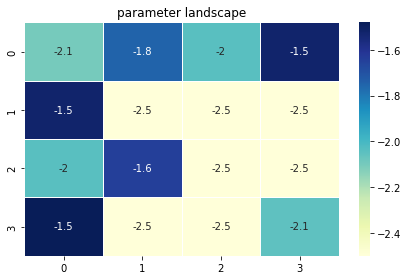

In [133]:
ideal_param1, ideal_param2, lowest_energy=param_optimizer_device(param, param, Q, 100,'TN1')
print(ideal_param1, ideal_param2, lowest_energy)

Using IonQ

In [119]:
Qubits=11
max_val=2**Qubits
param=np.arange(0.2,0.5,0.1,dtype=float)
print(param)

[0.2 0.3 0.4]


0 1.3
1 0.51
2 0.84
3 0.75
4 0.27
5 0.15
6 0.35
7 0.25
8 0.5
9 0.6
10 0.1
T   : |0|1|    2     |    3     |    4     |        5         |         6         |             7             |              8              |                 9                  |                   10                   |                      11                       |                       12                        |                       13                       |                  14                   |                  15                  |              16              |             17              |        18        |        19         |   20   |   21    |  22   |
                                                                                                                                                                                                                                                                                                                                                                 

Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
device Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
num reads 100
device cost per  shot : $ 0.01
total cost for 100 shots is $1.30
{1600: 1, 1040: 1, 528: 1, 1072: 1, 1384: 1, 1976: 1, 1828: 1, 1764: 1, 1364: 1, 884: 1, 1036: 1, 908: 1, 812: 1, 1964: 1, 1004: 1, 1596: 1, 1404: 1, 1916: 1, 2044: 1, 1698: 1, 842: 1, 682: 1, 890: 1, 1914: 1, 762: 1, 1254: 1, 1558: 1, 1366: 1, 1462: 1, 1398: 1, 1806: 1, 686: 2, 542: 1, 1374: 1, 830: 1, 1681: 1, 209: 1, 1841: 2, 1393: 1, 881: 1, 73: 1, 1385: 1, 1913: 1, 645: 1, 1669: 1, 1093: 1, 1349: 1, 1477: 1, 1061: 1, 1701: 1, 1421: 1, 1485: 1, 301: 1, 365: 1, 877: 1, 637: 1, 893: 1, 1917: 1, 765: 1, 1533: 1, 1795: 1, 803: 1, 1875: 1, 1267: 2, 1547: 1, 779: 1, 651: 1, 299: 2, 1771: 1, 1371: 1, 59: 1, 1851: 1, 1211: 1, 1723: 2, 123: 1, 1147: 1, 891: 1, 1915: 1, 327: 1, 199: 1, 999: 1, 527: 1, 1871: 1, 1583: 1, 751: 1, 1567: 1, 1823: 1, 1695:

Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
device Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
num reads 100
device cost per  shot : $ 0.01
total cost for 100 shots is $1.30
{320: 1, 832: 1, 176: 1, 688: 1, 1392: 1, 296: 1, 1656: 1, 376: 2, 548: 1, 1956: 1, 1364: 1, 884: 1, 1908: 1, 268: 1, 588: 1, 1996: 1, 796: 1, 252: 1, 2044: 1, 2: 1, 146: 1, 50: 1, 1074: 1, 1482: 1, 986: 1, 1606: 1, 1702: 1, 1686: 1, 950: 1, 1654: 1, 886: 1, 1614: 1, 1582: 1, 1198: 1, 686: 1, 1646: 1, 1310: 1, 1214: 1, 638: 1, 897: 1, 1857: 1, 1681: 1, 721: 1, 1585: 1, 881: 1, 681: 1, 873: 1, 601: 1, 1753: 1, 1081: 1, 1849: 1, 441: 1, 121: 1, 1913: 1, 761: 1, 197: 1, 1829: 1, 741: 1, 885: 1, 781: 2, 1933: 1, 845: 2, 1965: 1, 1645: 1, 1773: 1, 477: 1, 829: 1, 1725: 1, 637: 1, 1917: 1, 1533: 1, 1891: 1, 1939: 1, 1779: 1, 1995: 1, 1755: 1, 327: 1, 711: 1, 1191: 1, 1943: 1, 983: 1, 823: 1, 1271: 1, 1783: 1, 2039: 1, 1295: 1, 399: 1, 1615: 1, 1839: 

Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
device Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
num reads 100
device cost per  shot : $ 0.01
total cost for 100 shots is $1.30
{512: 1, 384: 1, 888: 1, 772: 1, 740: 1, 340: 1, 1844: 1, 1140: 1, 372: 1, 1908: 1, 244: 1, 1996: 1, 1836: 1, 284: 1, 1884: 1, 1660: 1, 2044: 1, 98: 1, 1554: 1, 1810: 1, 1898: 1, 1722: 1, 1894: 1, 1782: 1, 558: 1, 1118: 1, 1630: 1, 894: 1, 2046: 3, 1409: 1, 321: 1, 929: 1, 1377: 1, 1585: 1, 497: 1, 905: 1, 1321: 1, 2009: 1, 37: 1, 1125: 1, 1893: 1, 741: 1, 949: 1, 885: 1, 501: 1, 2037: 1, 781: 1, 1357: 1, 749: 1, 1517: 1, 957: 1, 1917: 1, 515: 1, 835: 1, 1171: 1, 1875: 1, 1971: 1, 1651: 1, 2035: 1, 651: 1, 555: 1, 1579: 1, 683: 1, 1707: 1, 1643: 1, 1259: 1, 1435: 1, 1083: 1, 571: 1, 443: 1, 1787: 1, 1543: 1, 1239: 1, 2007: 1, 1591: 1, 631: 1, 759: 1, 1783: 1, 1039: 1, 143: 1, 591: 1, 1743: 1, 815: 1, 1839: 1, 1519: 1, 1007: 1, 2031: 1, 1823: 1,

Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
device Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
num reads 100
device cost per  shot : $ 0.01
total cost for 100 shots is $1.30
{1312: 1, 1248: 1, 1104: 1, 1672: 1, 1752: 1, 1464: 1, 1784: 1, 2040: 1, 276: 1, 1428: 1, 1620: 1, 1876: 1, 1140: 1, 1268: 1, 716: 1, 940: 1, 1820: 1, 668: 1, 924: 1, 636: 1, 1660: 1, 850: 1, 434: 1, 946: 1, 626: 1, 1834: 1, 678: 1, 1702: 1, 1254: 1, 1654: 1, 1742: 1, 1086: 1, 1918: 1, 1793: 1, 1297: 1, 1169: 1, 1617: 1, 1873: 1, 1137: 1, 625: 1, 1777: 3, 809: 1, 889: 1, 1285: 1, 1605: 1, 1765: 1, 1205: 1, 757: 1, 877: 1, 1885: 1, 637: 1, 381: 1, 893: 1, 1917: 1, 765: 1, 1789: 1, 2045: 1, 1667: 1, 1987: 1, 1875: 1, 1587: 1, 947: 1, 1971: 1, 1907: 1, 1779: 1, 11: 1, 1371: 1, 1211: 1, 699: 1, 1915: 1, 1787: 1, 839: 1, 1735: 1, 1831: 1, 1879: 1, 727: 1, 823: 1, 1719: 1, 1655: 1, 1807: 2, 1359: 1, 1871: 2, 815: 1, 751: 2, 1775: 1, 1311: 1, 607: 1, 

Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
device Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
num reads 100
device cost per  shot : $ 0.01
total cost for 100 shots is $1.30
{1984: 1, 736: 1, 560: 1, 1712: 1, 1392: 1, 1704: 1, 1336: 1, 1848: 1, 1540: 1, 1924: 1, 964: 1, 1828: 1, 308: 1, 692: 1, 1140: 1, 1652: 1, 1964: 1, 1820: 1, 1116: 1, 732: 1, 2012: 1, 700: 2, 636: 1, 892: 1, 1916: 2, 1276: 1, 2044: 1, 1794: 1, 130: 1, 626: 1, 1394: 1, 1562: 1, 858: 1, 1638: 1, 358: 1, 726: 1, 1038: 1, 654: 1, 1870: 1, 286: 1, 1438: 1, 1726: 1, 1982: 1, 1790: 1, 673: 1, 401: 1, 593: 1, 2001: 1, 1329: 1, 1969: 1, 1137: 2, 1649: 1, 369: 1, 1905: 1, 1161: 1, 1417: 1, 1001: 1, 1593: 1, 825: 1, 633: 1, 1529: 1, 645: 1, 1413: 2, 1349: 1, 1557: 1, 1365: 1, 1877: 1, 1909: 1, 525: 1, 1357: 1, 749: 1, 1437: 1, 1949: 1, 1629: 1, 733: 1, 637: 1, 1277: 1, 765: 1, 1859: 1, 1987: 1, 291: 1, 1907: 1, 1779: 1, 1387: 1, 1627: 1, 2011: 1, 571: 1, 

Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
device Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
num reads 100
device cost per  shot : $ 0.01
total cost for 100 shots is $1.30
{528: 1, 400: 1, 1072: 1, 880: 2, 752: 1, 840: 1, 296: 1, 600: 1, 1860: 1, 1444: 1, 1508: 1, 1876: 1, 1524: 1, 1484: 1, 1996: 1, 1836: 1, 492: 1, 156: 1, 1628: 1, 882: 1, 754: 1, 1778: 2, 1738: 1, 746: 1, 1530: 1, 1350: 1, 38: 1, 1638: 1, 1102: 1, 798: 1, 350: 1, 1758: 1, 62: 1, 1342: 1, 1726: 1, 958: 2, 638: 1, 894: 1, 1729: 1, 1633: 1, 737: 1, 1233: 1, 753: 1, 497: 1, 1033: 1, 1145: 1, 761: 1, 505: 1, 725: 1, 821: 1, 525: 1, 1453: 1, 1261: 1, 29: 1, 1757: 1, 1597: 1, 829: 2, 637: 1, 381: 1, 1917: 1, 1021: 1, 1539: 1, 931: 1, 867: 1, 1555: 1, 787: 1, 211: 1, 691: 2, 523: 1, 779: 1, 971: 1, 1387: 1, 1259: 1, 251: 1, 1787: 1, 2043: 1, 1287: 1, 1191: 1, 439: 1, 887: 2, 1807: 1, 1999: 1, 1391: 1, 575: 1, 1599: 1, 831: 1, 703: 2, 959: 1, 1983: 1, 1

Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
device Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
num reads 100
device cost per  shot : $ 0.01
total cost for 100 shots is $1.30
{1824: 1, 784: 1, 1584: 1, 432: 1, 1392: 1, 1976: 1, 708: 1, 1828: 1, 868: 1, 228: 1, 820: 1, 1652: 1, 1012: 1, 1292: 1, 844: 1, 876: 1, 1772: 1, 700: 2, 1660: 1, 1916: 1, 1276: 1, 1532: 1, 1826: 1, 850: 1, 818: 1, 538: 1, 1850: 1, 1786: 1, 1734: 1, 1038: 1, 1886: 1, 638: 1, 1918: 1, 1790: 1, 641: 1, 1345: 1, 1217: 1, 673: 1, 1633: 1, 353: 1, 1761: 1, 209: 1, 177: 1, 1393: 2, 881: 1, 753: 1, 1881: 2, 1465: 1, 633: 2, 889: 1, 1913: 1, 1141: 1, 629: 1, 373: 1, 1909: 1, 1781: 1, 845: 1, 1133: 1, 1773: 1, 797: 1, 349: 1, 1981: 1, 893: 1, 1917: 2, 1987: 1, 931: 1, 611: 1, 1763: 1, 1043: 1, 1875: 1, 819: 1, 779: 1, 1995: 1, 683: 1, 875: 1, 747: 1, 827: 1, 1851: 1, 443: 1, 1659: 1, 1351: 1, 1255: 1, 487: 1, 1295: 1, 1871: 1, 719: 1, 1839: 2, 1263: 1, 

Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
device Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
num reads 100
device cost per  shot : $ 0.01
total cost for 100 shots is $1.30
{1792: 1, 1760: 1, 1392: 1, 232: 1, 1000: 1, 1112: 1, 1860: 1, 1060: 1, 1508: 1, 788: 1, 756: 1, 1780: 1, 1740: 1, 1052: 1, 1564: 1, 1692: 1, 860: 1, 572: 1, 1660: 1, 892: 1, 770: 1, 962: 1, 674: 1, 354: 1, 1394: 1, 746: 1, 1338: 1, 1942: 1, 1654: 1, 1910: 1, 1966: 1, 1054: 1, 1694: 1, 1438: 1, 702: 1, 894: 1, 1918: 1, 1505: 1, 1585: 1, 1393: 1, 1905: 2, 1737: 1, 1961: 1, 1881: 1, 569: 1, 313: 1, 1401: 1, 889: 2, 1913: 2, 1749: 1, 1077: 2, 821: 1, 885: 1, 781: 1, 557: 1, 1773: 1, 1437: 1, 637: 1, 381: 1, 893: 1, 1917: 1, 1277: 1, 765: 1, 1533: 1, 1859: 1, 1251: 1, 2003: 1, 563: 1, 1203: 1, 1459: 1, 1907: 1, 1523: 1, 1707: 1, 875: 1, 1211: 1, 1787: 2, 1703: 1, 343: 1, 591: 1, 1871: 1, 975: 2, 1071: 1, 1327: 1, 815: 1, 687: 1, 1967: 1, 879: 2, 10

Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
device Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
num reads 100
device cost per  shot : $ 0.01
total cost for 100 shots is $1.30
{768: 1, 1472: 1, 1424: 1, 840: 1, 1944: 1, 1912: 1, 1860: 1, 468: 1, 1868: 1, 428: 1, 876: 1, 28: 1, 1500: 1, 956: 2, 882: 1, 1562: 1, 2010: 1, 634: 1, 1574: 1, 358: 1, 630: 1, 782: 1, 1678: 1, 398: 1, 1102: 1, 238: 1, 750: 1, 1854: 1, 1: 1, 1537: 1, 1281: 1, 769: 1, 321: 1, 1377: 1, 593: 1, 209: 1, 2001: 1, 1841: 1, 1649: 1, 1393: 1, 1369: 1, 857: 1, 633: 1, 1913: 1, 1285: 1, 1861: 1, 229: 1, 373: 1, 757: 1, 845: 2, 941: 1, 1965: 1, 237: 1, 285: 1, 797: 1, 1437: 1, 733: 1, 829: 1, 637: 1, 509: 1, 1021: 1, 771: 1, 131: 1, 1603: 1, 883: 1, 1523: 1, 779: 1, 1931: 1, 1883: 1, 827: 2, 1211: 1, 123: 1, 1147: 1, 1659: 3, 1915: 1, 1275: 1, 763: 1, 2043: 1, 871: 1, 2007: 2, 311: 1, 1271: 1, 1679: 1, 1263: 1, 751: 1, 671: 3, 1695: 1, 607: 1, 1983: 1, 6

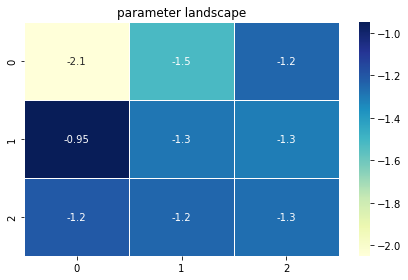

In [120]:
ideal_param1, ideal_param2, lowest_energy=param_optimizer_device(param, param, Q, 100,'IonQ Device')
print(ideal_param1, ideal_param2, lowest_energy)

### Find minimum using fixed parameters

In [84]:
#---------
param1=[0.27723358]
param2=[0.28702843]
shots=1000
#---------

Using Local Simulator

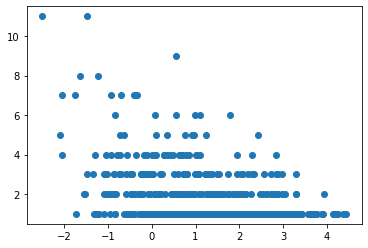

11000001111 -2.5000000000000004 11


In [85]:
solution,energy,quantity=optimize_bqm(param1, param2, Q, shots)
print(solution, energy, quantity)

### Scheduling Tasks

Using IonQ

In [86]:
device=set_device('IonQ Device')

Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)


In [87]:
estimate_cost(device,num_shots=shots)

device cost per  shot : $ 0.01
total cost for 1000 shots is $10.30


In [ ]:
task_id=schedule_optimize_bqm_task(param1, param2, Q, shots, device)
print(task_id)

100 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice.


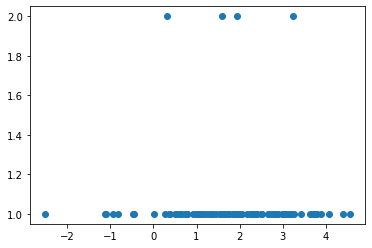

minimum found -2.5000000000000004


In [64]:
results, metadata, counts=recover_task(task_id)
solution=[]
quantity=[]
energy=[]
for keys,values in zip(counts.keys(),counts.values()):
    solution.append(keys)
    quantity.append(values)
    energy.append(sum_energy(Q,keys))
energy_np=np.array(energy)
index=np.argsort(energy)
plt.scatter(energy,quantity)
plt.show()
print('minimum found', energy[index[0]])

Using Rigetti

In [ ]:
shots=1000
#device=set_device('Aspen-M-1')
device=set_device('Aspen-11')
estimate_cost(device,num_shots=shots)
task_id=schedule_optimize_bqm_task(param1, param2, Q, shots, device)
print(task_id)

In [70]:
results, metadata, counts=recover_task(task_id)
solution=[]
quantity=[]
energy=[]
for keys,values in zip(counts.keys(),counts.values()):
    solution.append(keys)
    quantity.append(values)
    energy.append(sum_energy(Q,keys))
energy_np=np.array(energy)
index=np.argsort(energy)
plt.scatter(energy,quantity)
plt.show()
print('minimum found', energy[index[0]])

Sorry, your task is still being processed and has not been finalized yet.


TypeError: cannot unpack non-iterable NoneType object

Determine minimum using multiple step parameters

Using fixed parameters and Local Simulator

In [65]:
#---------
param1=[0.2, 0.25, 0.3, 0.2]
param2=[0.3, 0.3, 0.2, 0.2]
shots=1000
#---------

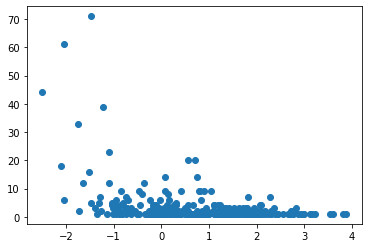

11000001111 -2.5000000000000004 44


In [91]:
solution,energy,quantity=optimize_bqm(param1, param2, Q, shots)
print(solution, energy, quantity)

Using IonQ

In [92]:
device=set_device('IonQ Device')

Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)


In [93]:
estimate_cost(device,num_shots=shots)

device cost per  shot : $ 0.01
total cost for 1000 shots is $10.30


In [ ]:
task_id=schedule_optimize_bqm_task(param1, param2, Q, shots, device)
print(task_id)

1000 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice.


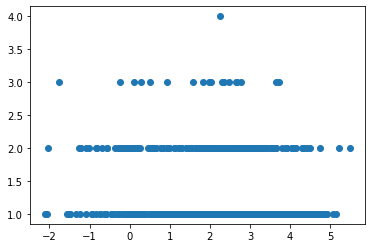

minimum found -2.0999999999999996


In [115]:
results, metadata, counts=recover_task(task_id)
solution=[]
quantity=[]
energy=[]
for keys,values in zip(counts.keys(),counts.values()):
    solution.append(keys)
    quantity.append(values)
    energy.append(sum_energy(Q,keys))
energy_np=np.array(energy)
index=np.argsort(energy)
plt.scatter(energy,quantity)
plt.show()
print('minimum found', energy[index[0]])

Using Rigetti

Using optimal values found for 2 cycles

In [ ]:
#---------
param1=[0.25, 0.4]
param2=[0.35, 0.4]
shots=1000
#---------
device=set_device('IonQ Device')
estimate_cost(device,num_shots=shots)
task_id=schedule_optimize_bqm_task(param1, param2, Q, shots, device)
print(task_id)


1000 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice.


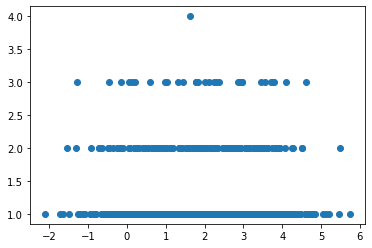

minimum found -2.0999999999999996


In [54]:
results, metadata, counts=recover_task(task_id)
solution=[]
quantity=[]
energy=[]
for keys,values in zip(counts.keys(),counts.values()):
    solution.append(keys)
    quantity.append(values)
    energy.append(sum_energy(Q,keys))
energy_np=np.array(energy)
index=np.argsort(energy)
plt.scatter(energy,quantity)
plt.show()
print('minimum found', energy[index[0]])

In [ ]:
shots=1000
#device=set_device('Aspen-M-1')
device=set_device('Aspen-11')
estimate_cost(device,num_shots=shots)
task_id=schedule_optimize_bqm_task(param1, param2, Q, shots, device)
print(task_id)

1000 shots taken on machine arn:aws:braket:::device/qpu/rigetti/Aspen-11.


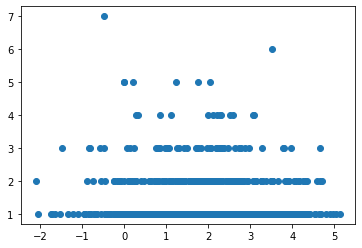

minimum found -2.0999999999999996


In [56]:
results, metadata, counts=recover_task(task_id)
solution=[]
quantity=[]
energy=[]
for keys,values in zip(counts.keys(),counts.values()):
    solution.append(keys)
    quantity.append(values)
    energy.append(sum_energy(Q,keys))
energy_np=np.array(energy)
index=np.argsort(energy)
plt.scatter(energy,quantity)
plt.show()
print('minimum found', energy[index[0]])

## 2. Optimize n qubit nxn matrix with multiple solutions

Generate a matrix for desired number of Qubits

Optimizing 14x14 matrix

In [35]:
Qubits=14
Q14=generate_matrix(Qubits)
print(Q14)

100
[[-5.  1.  1.  1.  2.  1.  1.  1.  2.  2.  1.  1.  3.  1.]
 [ 0. -4.  2.  2.  1.  2.  4.  2.  1.  1.  1.  2.  1.  1.]
 [ 0.  0. -5.  1.  2.  1.  1.  2.  1.  2.  1.  2.  1.  1.]
 [ 0.  0.  0. -3.  1.  1.  2.  1.  2.  1.  1.  1.  5.  1.]
 [ 0.  0.  0.  0. -4.  2.  1.  2.  1.  1.  1.  1.  3.  2.]
 [ 0.  0.  0.  0.  0. -3.  1.  1.  2.  1.  1.  3.  1.  2.]
 [ 0.  0.  0.  0.  0.  0. -3.  2.  2.  1.  1.  1.  2.  2.]
 [ 0.  0.  0.  0.  0.  0.  0. -3.  1.  2.  1.  2.  2.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -4.  2.  1.  1.  2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -3.  2.  2.  2.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -3.  1.  2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -3.  3.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -3.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -3.]]


In [57]:
shots=50
SV=False
Q=Q14
param1_list=[]
param2_list=[]
min_value_list=[]
solution_list=[]
quantity_list=[]
params=[0.3,0.3]
#res = minimize(func_bqm, params, method='Nelder-Mead', tol=0.001)
res = minimize(func_bqm, params, bounds=((0.1, 0.5), (0.1, 0.5)), method='Powell', tol=0.01)
#Nelder-Mead, Powell,COBYLA

In [58]:
print(res)

   direc: array([[ 0.        ,  1.        ],
       [-0.09653355, -0.17188752]])
     fun: -10.0
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 2
  status: 0
 success: True
       x: array([0.19805731, 0.25351363])


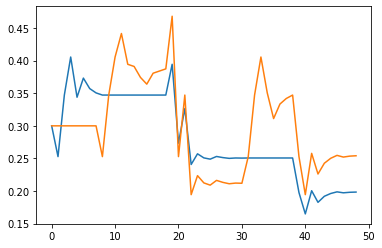

In [59]:
plt.plot(param1_list)
plt.plot(param2_list)
plt.show()

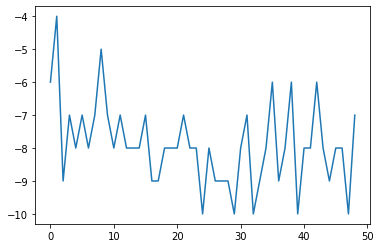

In [60]:
plt.plot(min_value_list)
plt.show()

In [61]:
unique_solutions=[]
min_energy=99999
for i in range(len(solution_list)):
    print(solution_list[i],quantity_list[i], min_value_list[i])
    if min_value_list[i]<min_energy:
        min_energy=min_value_list[i]
        unique_solutions=[]
        unique_solutions.append(solution_list[i])
    elif min_value_list[i]==min_energy:
        if solution_list[i] not in unique_solutions:
            unique_solutions.append(solution_list[i])
print('Minimum energy solutions')
print(min_energy,unique_solutions)        
    

10110110001000 1 -6.0
00010001011000 1 -4.0
11001000001000 1 -9.0
01000000001001 1 -7.0
11110000000001 1 -8.0
10100110010000 1 -7.0
11000001000000 1 -8.0
01001000101100 1 -7.0
11000100011000 1 -5.0
10110010000100 1 -7.0
00100100101000 1 -8.0
11000000110000 1 -7.0
10011000000000 1 -8.0
11000000010000 1 -8.0
11101000100000 1 -8.0
00100010000000 1 -7.0
11001000100000 1 -9.0
10110000000100 1 -9.0
01001000100100 1 -8.0
10001000000100 1 -8.0
11000100000000 1 -8.0
10010000100001 1 -7.0
00100100000010 1 -8.0
00110000001001 1 -8.0
11100000100000 1 -10.0
01001000100100 1 -8.0
10100010000001 1 -9.0
10110001000000 1 -9.0
11001000001000 1 -9.0
11100000100000 1 -10.0
00110000001000 1 -8.0
10100000011000 1 -7.0
11100000000000 1 -10.0
11000000000001 1 -9.0
10000010000100 1 -8.0
00011010010000 1 -6.0
10100000000000 1 -9.0
11001000000100 1 -8.0
00001110010000 1 -6.0
11100000000000 1 -10.0
10000000100100 1 -8.0
00101000001000 1 -8.0
00100000000100 1 -6.0
00101000001000 1 -8.0
10100000000000 1 -9.0
011010

In [ ]:
# 10100100001000 1 -10.0 (missing?)

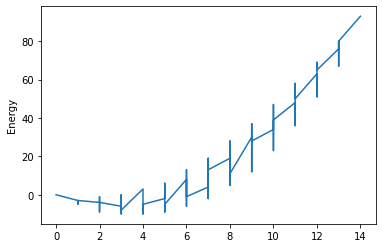

Best found: [0, 2, 3]
count: 3
Energy: -10.0
Solutions Sampled: 12942


([0, 2, 3],
 -10.0,
 [1, 14, 91, 364, 1001, 2002, 3003, 3432, 3003, 2002, 1001, 364, 91, 14, 1])

In [62]:
ProbabilisticSampler(Q14,2000)

Optimizing a 34x34 matrix

In [71]:
Qubits=34
Q34=generate_matrix(Qubits)
print(Q34)

100
[[-5.  1.  1. ...  1.  1.  2.]
 [ 0. -4.  2. ...  2.  1.  1.]
 [ 0.  0. -5. ...  1.  2.  2.]
 ...
 [ 0.  0.  0. ... -3.  2.  1.]
 [ 0.  0.  0. ...  0. -3.  3.]
 [ 0.  0.  0. ...  0.  0. -3.]]


In [65]:
# Cannot use Local Simulator

Using SV1

In [66]:
device=set_device('SV1')
estimate_cost(device,num_shots=100)

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
simulator cost per  minute : $ 0.075
total cost cannot be estimated


0 -5.0
1 -4.0
2 -5.0
3 -3.0
4 -4.0
5 -3.0
6 -3.0
7 -3.0
8 -4.0
9 -3.0
10 -3.0
11 -3.0
12 -3.0
13 -3.0
14 -3.0
15 -3.0
16 -3.0
17 -3.0
18 -3.0
19 -4.0
20 -4.0
21 -3.0
22 -3.0
23 -3.0
24 -4.0
25 -3.0
26 -4.0
27 -4.0
28 -3.0
29 -5.0
30 -4.0
31 -3.0
32 -3.0
33 -3.0
T   : |0|1|   2   |   3   |   4   |       5       |       6       |           7           |           8           |               9               |              10               |                  11                   |                  12                   |                      13                       |                      14                       |                          15                           |                          16                           |                             17                              |                              18                               |                                  19                                   |                                  20                                   | 

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total cost cannot be estimated
{698316760: 1, 2462917320: 1, 5430478059: 1, 6446191212: 1, 1563292852: 1, 7191652705: 1, 2820592015: 1, 11633972204: 1, 10932872340: 1, 11708397325: 1, 1732872050: 1, 3713202520: 1, 3969317958: 1, 9285019582: 1, 11342628193: 1, 15787413644: 1, 13362203784: 1, 58451906: 1, 16020824182: 1, 16321103852: 1, 3227731793: 1, 12440052126: 1, 10146003076: 1, 16784005360: 1, 13254019961: 1, 9767321153: 1, 15864853511: 1, 16068673977: 1, 10685979571: 1, 14702880939: 1, 5174194798: 1, 1487561496: 1, 4029537479: 1, 13481494618: 1, 14288677761: 1, 12813355075: 1, 5879073912: 1, 9905442896: 1, 10952028081: 1, 1681838820: 1, 4937579876: 1, 5932934428: 1, 11146025916: 1, 9581303015: 1, 859424119: 1, 14745981499: 1, 10229315476: 1, 17026580585: 1, 77756673

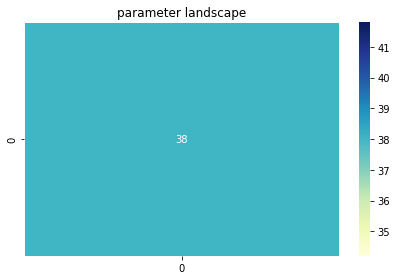

In [67]:
Qubits=len(Q34)
max_val=2**Qubits
#param=np.arange(0.2,0.7,0.1,dtype=float)
param=np.arange(0.2,0.3,0.1,dtype=float)
ideal_param1, ideal_param2, lowest_energy=param_optimizer_device(param, param, Q34, 100,'SV1')
print(ideal_param1, ideal_param2, lowest_energy)

In [ ]:
#took approx 1 hr to run.

Using TN1

In [ ]:
device=set_device('TN1')
estimate_cost(device,num_shots=100)

In [72]:
Qubits=len(Q34)
max_val=2**Qubits
#param=np.arange(0.2,0.7,0.1,dtype=float)
param=np.arange(0.2,0.3,0.1,dtype=float)
ideal_param1, ideal_param2, lowest_energy=param_optimizer_device(param, param, Q34, 1000,'TN1')
print(ideal_param1, ideal_param2, lowest_energy)

T   : |0|1|   2   |   3   |   4   |       5       |       6       |           7           |           8           |               9               |              10               |                  11                   |                  12                   |                      13                       |                      14                       |                          15                           |                          16                           |                             17                              |                              18                               |                                  19                                   |                                  20                                   |                                      21                                       |                                      22                                       |                                          23                                           |               

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 1000


Task is in terminal state FAILED and no result is available.
Task failure reason is: Predicted runtime based on best contraction path found exceeds TN1 limit. Single-shot FLOPS estimate = 2^43.


AttributeError: 'NoneType' object has no attribute 'additional_metadata'

Using D-Wave Advantage

In [78]:
response=run_dwave(Q34)

Number of qubits:  5760
Number of couplers 40279
Shots max 10,000
429496729600
Recommended shots 10000
Estimated cost $2.20
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 ... 33 energy num_oc. ...
0     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ...  0   -9.0       1 ...
1     1  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0 ...  0   -8.0       1 ...
2     0  0  1  0  0  1  0  0  0  0  1  0  0  0  0  0 ...  0   -8.0       1 ...
3     1  0  1  0  0  0  1  0  0  0  0  1  0  0  0  0 ...  0   -8.0       1 ...
4     1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0 ...  0   -8.0       1 ...
5     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ...  0   -8.0       1 ...
6     0  0  1  0  0  1  0  0  0  1  0  0  0  0  0  0 ...  0   -7.0       1 ...
7     1  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0 ...  0   -7.0       1 ...
8     0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 ...  0   -7.0       1 ...
9     0  0  0  0  0  1  0  0  0  1  0  0  0  0  1  0 ...  0   -7.0       1 ...
10    0

In [82]:
response=run_neal(Q34)

Sample(sample={0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 1, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0}, energy=-12.0, num_occurrences=1)
{0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 1, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0}
1010000000000000000010000001000000
10737426496


Using probabilistic sampler

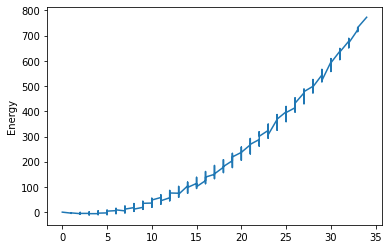

Best found: [0, 2, 27]
count: 3
Energy: -11.0
Solutions Sampled: 59192


([0, 2, 27],
 -11.0,
 [1,
  34,
  561,
  5984,
  46376,
  278256,
  1344904,
  5379616,
  18156204,
  52451256,
  131128140,
  286097760,
  548354040,
  927983760,
  1391975640,
  1855967520,
  2203961430,
  2333606220,
  2203961430,
  1855967519,
  1391975640,
  927983760,
  548354040,
  286097760,
  131128140,
  52451256,
  18156204,
  5379616,
  1344904,
  278256,
  46376,
  5984,
  561,
  34,
  1])

In [73]:
ProbabilisticSampler(Q34,2000)

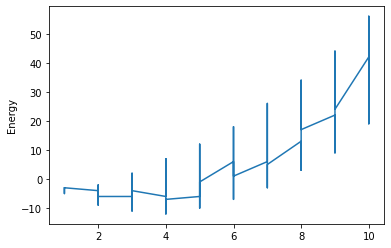

Best found: [0, 2, 20, 27]
count: 4
Energy: -12.0
Solutions Sampled: 146579


([0, 2, 20, 27],
 -12.0,
 [34,
  561,
  5984,
  46376,
  278256,
  1344904,
  5379616,
  18156204,
  52451256,
  131128140])

In [74]:
ProbabilisticSampler(Q34,20000,0,1,10)

## 3. Optimizing up to 38x38 sparse matrix

Using Rigetti Aspen-11 or Aspen M-1

Device('name': Aspen-11, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-11)


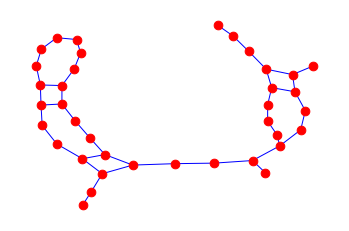

In [101]:
# Run only first time if creating the Aspen_matrix file. Each time a random matrix is created.
# create_aspen_11_matrix()
# create_aspen_M-1_matrix()

Evaluate Aspen Matrix on graph

In [104]:
file = open("Aspen_matrix.csv")
A = np.loadtxt(file, delimiter=",")
file.close()

In [91]:
# cannot run Local Simulator

Using Aspen-11

[0.2 0.5]
0 -2.0
1 -2.0
2 -4.0
3 -1.0
4 -1.0
5 -1.0
6 -1.0
7 -2.0
10 -4.0
11 -1.0
12 -4.0
13 -2.0
14 -1.0
15 -4.0
16 -1.0
17 -4.0
20 -4.0
21 -3.0
22 -3.0
23 -2.0
24 -2.0
25 -4.0
26 -4.0
27 -2.0
30 -4.0
31 -2.0
32 -2.0
33 -3.0
34 -4.0
35 -3.0
36 -3.0
37 -3.0
42 -2.0
43 -1.0
44 -1.0
45 -2.0
46 -4.0
47 -4.0
T   : |0|1|   2   |3|   4    |5|       6       |   7    | 8 |           9           |   10   | 11  |       12        |   13   | 14  |  15   |   16   |17|  18   |   19   |20|  21   |   22   |23|  24   |
                                                                                                                                                                                                         
q0  : -X-H-Rz(0.8)-C----------C-C------------------------C---Rx(0.4)-------------------------------------------------------------------------------------------------------------------------------------
                   |          | |                        |                              

Device('name': Aspen-11, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-11)
device Device('name': Aspen-11, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-11)
num reads 100
device cost per  shot : $ 0.00035
total cost for 100 shots is $0.33
{17717945603: 1, 48611323995: 1, 31435258587: 1, 176454307046: 1, 108741173446: 1, 73458510222: 1, 104477695135: 1, 78482229907: 1, 207229980295: 1, 76590830248: 1, 68732945677: 1, 173497182101: 1, 109340199299: 1, 159386625625: 1, 250525164185: 1, 193549227714: 1, 37813366962: 1, 223677701850: 1, 99072556995: 1, 21499823034: 1, 229586563602: 1, 270398333265: 1, 9871462098: 1, 176448273840: 1, 75220063562: 1, 70081506295: 1, 151489866311: 1, 74179266383: 1, 209777661281: 1, 18535559265: 1, 104219784552: 1, 77430519035: 1, 12955937506: 1, 145456598348: 1, 34712043589: 1, 39258590087: 1, 49616512586: 1, 92731364932: 1, 35575445831: 1, 134376355819: 1, 222356562190: 1, 103480290839: 1, 107985945787: 1, 89686074091: 1, 22102343070: 1, 220208555847: 

Device('name': Aspen-11, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-11)
device Device('name': Aspen-11, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-11)
num reads 100
device cost per  shot : $ 0.00035
total cost for 100 shots is $0.33
{25786742019: 1, 206615429754: 1, 265670736022: 1, 97368094926: 1, 128609419023: 1, 96059477967: 1, 246455707055: 1, 180195385565: 1, 76461912791: 1, 106660020561: 1, 260934058811: 1, 145673606643: 1, 117661068287: 1, 219029039127: 1, 135352091693: 1, 162189394228: 1, 226717064171: 1, 93246321340: 1, 192617949559: 1, 89250063477: 1, 213894163015: 1, 107853250071: 1, 249521595377: 1, 237791759247: 1, 40633877578: 1, 271602110035: 1, 148728764411: 1, 57401980701: 1, 232485196823: 1, 97259249111: 1, 56726327263: 1, 248125942421: 1, 235752219991: 1, 110525705719: 1, 265962171948: 1, 28774462047: 1, 90054317743: 1, 127866357966: 1, 100616080087: 1, 261249516786: 1, 136377786451: 1, 269603443477: 1, 102637179198: 1, 80874406580: 1, 242415363093: 1, 15

Device('name': Aspen-11, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-11)
device Device('name': Aspen-11, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-11)
num reads 100
device cost per  shot : $ 0.00035
total cost for 100 shots is $0.33
{17718977795: 1, 229502846863: 1, 196747781900: 1, 106367344991: 1, 220505943963: 1, 179167881295: 1, 124102942965: 1, 17774225198: 1, 195629545198: 1, 209919456740: 1, 235323500721: 1, 217460895241: 1, 7237574814: 1, 226113761166: 1, 239183139793: 1, 84031040727: 1, 68759944463: 1, 143434638743: 1, 206661150055: 1, 214132710605: 1, 241627999595: 1, 130615483810: 1, 19091746190: 1, 19200798346: 1, 32970816978: 1, 88205983790: 1, 92465827777: 1, 92437114904: 1, 77525318353: 1, 250207809238: 1, 248926954687: 1, 228385391062: 1, 238676704983: 1, 269245338702: 1, 70113619119: 1, 144437112471: 1, 106040231380: 1, 208729991057: 1, 239511205783: 1, 239258353655: 1, 210644579751: 1, 212787963085: 1, 209970003353: 1, 264806787615: 1, 264710606523: 1, 221

Device('name': Aspen-11, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-11)
device Device('name': Aspen-11, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-11)
num reads 100
device cost per  shot : $ 0.00035
total cost for 100 shots is $0.33
{52094977283: 1, 234835356495: 1, 31094730490: 1, 127103076335: 1, 201535861898: 1, 28961400558: 1, 125590972174: 1, 72059317071: 1, 87095766200: 1, 105794973764: 1, 38369485910: 1, 44792523535: 1, 80829299531: 1, 136397966154: 1, 75863714761: 1, 129095287784: 1, 115854867257: 1, 38184805707: 1, 108170808969: 1, 33684276892: 1, 138329122220: 1, 75615155246: 1, 138180941328: 1, 71634251720: 1, 58843637486: 1, 89518812103: 1, 259246686175: 1, 112842664783: 1, 162193254092: 1, 115845604218: 1, 170690659895: 1, 50265193237: 1, 101073936927: 1, 24283858344: 1, 228647218458: 1, 115513734986: 1, 81033831628: 1, 41004365710: 1, 201810522065: 1, 3482121392: 1, 98607557848: 1, 77046048654: 1, 221407682708: 1, 272267597088: 1, 35686573135: 1, 144451792603:

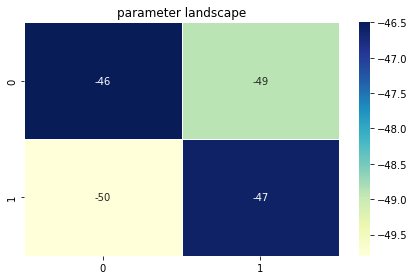

In [128]:
Qubits=len(A)
max_val=2**Qubits
param=np.arange(0.2,0.7,0.3,dtype=float)

print(param)
#ideal_param1, ideal_param2, lowest_energy=param_optimizer_device(param, param, A, 100,'Aspen-M-1')
ideal_param1, ideal_param2, lowest_energy=param_optimizer_device(param, param, A, 100,'Aspen-11')
print(ideal_param1, ideal_param2, lowest_energy)

Using TN1

In [ ]:
#TN1 does not allow gaps where qubits are not used. Thus matrix has to be converted to one where all qubits are used.

In [92]:
file = open("Aspen_matrix.csv")
T_raw = np.loadtxt(file, delimiter=",")
file.close()

In [93]:
print(len(T_raw[0]),len(T_raw[1]))

48 48


In [94]:
print(T_raw)

[[-4.   0.3  0.  ...  0.   0.   0. ]
 [ 0.  -3.   1.7 ...  0.   0.   0. ]
 [ 0.   0.  -1.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ... -2.   0.6  0. ]
 [ 0.   0.   0.  ...  0.  -3.   1.8]
 [ 0.   0.   0.  ...  0.   0.  -1. ]]


In [107]:
TN=convert_aspen_to_tn1(A)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 10: 8, 11: 9, 12: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15, 20: 16, 21: 17, 22: 18, 23: 19, 24: 20, 25: 21, 26: 22, 27: 23, 30: 24, 31: 25, 32: 26, 33: 27, 34: 28, 35: 29, 36: 30, 37: 31, 42: 32, 43: 33, 44: 34, 45: 35, 46: 36, 47: 37}
[[-2.   0.1  0.  ...  0.   0.   0. ]
 [ 0.  -2.   0.7 ...  0.   0.   0. ]
 [ 0.   0.  -4.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ... -2.   0.2  0. ]
 [ 0.   0.   0.  ...  0.  -4.   1.3]
 [ 0.   0.   0.  ...  0.   0.  -4. ]]
(38, 38)


[0.2 0.5]
0 -2.0
1 -2.0
2 -4.0
3 -1.0
4 -1.0
5 -1.0
6 -1.0
7 -2.0
8 -4.0
9 -1.0
10 -4.0
11 -2.0
12 -1.0
13 -4.0
14 -1.0
15 -4.0
16 -4.0
17 -3.0
18 -3.0
19 -2.0
20 -2.0
21 -4.0
22 -4.0
23 -2.0
24 -4.0
25 -2.0
26 -2.0
27 -3.0
28 -4.0
29 -3.0
30 -3.0
31 -3.0
32 -2.0
33 -1.0
34 -1.0
35 -2.0
36 -4.0
37 -4.0
T   : |0|1|   2   |   3    |        4        |            5             |            6             |   7    |   8    |   9    |  10   |
                                                                                                                                       
q0  : -X-H-Rz(0.8)-ZZ(0.04)-ZZ(0.12)----------Rx(0.4)----------------------------------------------------------------------------------
                   |        |                                                                                                          
q1  : -X-H-Rz(0.8)-ZZ(0.04)-|--------ZZ(0.28)-ZZ(0.12)-------------------Rx(0.4)-------------------------------------------------------
                

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{128845330427: 1, 128542616938: 1, 90108145403: 1, 59789523622: 1, 42613975919: 1, 261439240441: 1, 248902264607: 1, 193003443685: 1, 137367603700: 1, 201529400187: 1, 94430262519: 1, 270602860427: 1, 184470926619: 1, 60108240255: 1, 219760394089: 1, 117480687703: 1, 55464922984: 1, 119820548709: 1, 194706246967: 1, 61255257544: 1, 27685781291: 1, 251730279667: 1, 136813196515: 1, 127089291263: 1, 234024959466: 1, 59414950889: 1, 185986787539: 1, 184524166637: 1, 179404823487: 1, 197261196173: 1, 264102196215: 1, 272924838731: 1, 59820601647: 1, 243611441487: 1, 253904214743: 1, 270817723165: 1, 39532818165: 1, 248624706999: 1, 245496016301: 1, 35063673326: 1, 113587516775: 1, 125956838868: 1, 187512645599: 1, 188038133383: 1, 248230810367

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{113782537204: 1, 12809391343: 1, 231789557530: 1, 119985796815: 1, 238336571373: 1, 235115605911: 1, 250978760155: 1, 264072314871: 1, 235329663999: 1, 262856371423: 1, 274705774565: 1, 132052462575: 1, 272696737515: 1, 237220397035: 1, 236206142957: 1, 98230370294: 1, 165859028727: 1, 231856925179: 1, 246624811775: 1, 273602311131: 1, 216711017711: 1, 247996316663: 1, 137371056084: 1, 249070343335: 1, 243730776047: 1, 268431122259: 1, 195119017936: 1, 271310127093: 1, 189974659055: 1, 270364044727: 1, 274877545911: 1, 240216178683: 1, 188945003515: 1, 246604103659: 1, 40793697627: 1, 246956273599: 1, 236171558869: 1, 270313713647: 1, 258409738231: 1, 180353756155: 1, 152194367479: 1, 263871704771: 1, 109244570541: 1, 124551724927: 1, 201

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{152215884105: 1, 235421068698: 1, 131736818015: 1, 243785104582: 1, 164119111288: 1, 87629181934: 1, 229687591537: 1, 175781421940: 1, 239520282180: 1, 216647356629: 1, 218195481395: 1, 162866651980: 1, 162949047488: 1, 250596803732: 1, 250047939643: 1, 206768617853: 1, 117364199061: 1, 259463876780: 1, 270412943280: 1, 186170148759: 1, 242307775071: 1, 145452742724: 1, 231267535024: 1, 229769047164: 1, 210050787040: 1, 242269969047: 1, 28403670235: 1, 41064378496: 1, 177802545805: 1, 231666426477: 1, 108453721556: 1, 127380506275: 1, 254891757498: 1, 51160478828: 1, 266296564843: 1, 268441265088: 1, 132476977407: 1, 202408848502: 1, 179857578667: 1, 263885084559: 1, 127570148164: 1, 134991759136: 1, 231500706815: 1, 252245712175: 1, 1691

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{121027272536: 1, 252788818803: 1, 253223107575: 1, 98518267760: 1, 235904656244: 1, 225222318172: 1, 209339695092: 1, 173335616915: 1, 195259421704: 1, 212254837903: 1, 218965228771: 1, 252867870668: 1, 252868334579: 1, 228719153264: 1, 252855440539: 1, 162724809783: 1, 168776570060: 1, 96643554360: 1, 210360845187: 1, 270103561004: 1, 209929096876: 1, 245992870656: 1, 213731282731: 1, 244154358445: 1, 173178282732: 1, 230397373000: 1, 185323401293: 1, 237708505436: 1, 169584630983: 1, 263662277616: 1, 226836569923: 1, 244327196652: 1, 235688140504: 1, 195278548986: 1, 73892520052: 1, 78555283404: 1, 237615598472: 1, 263076590320: 1, 184249903982: 1, 243479076407: 1, 258827885728: 1, 273448342476: 1, 209972482042: 1, 254214474989: 1, 2468

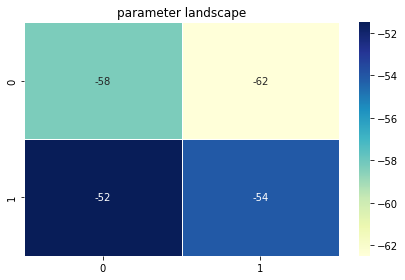

In [164]:
Qubits=len(TN)
max_val=2**Qubits
param=np.arange(0.2,0.7,0.1,dtype=float)

print(param)
ideal_param1, ideal_param2, lowest_energy=param_optimizer_device(param, param, TN, 100,'TN1')
print(ideal_param1, ideal_param2, lowest_energy)

Using D-Wave Advantage

In [116]:
response=run_dwave(TN)

Number of qubits:  5760
Number of couplers 40279
Shots max 10,000
6871947673600
Recommended shots 10000
Estimated cost $2.20
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 ... 37 energy num_oc. ...
0     1  1  1  0  1  0  1  1  1  0  1  1  0  1  0  1 ...  1  -67.8      71 ...
2724  1  1  1  0  1  0  1  1  1  0  1  1  0  1  0  1 ...  1  -67.8       1 ...
1     1  1  1  0  1  0  1  1  1  0  1  1  0  1  0  1 ...  1  -67.7      66 ...
550   1  1  1  0  1  0  1  1  1  0  1  1  0  1  0  1 ...  1  -67.7       1 ...
1128  1  1  1  0  1  0  1  1  1  0  1  1  0  1  0  1 ...  1  -67.7       1 ...
1129  1  1  1  0  1  0  1  1  1  0  1  1  0  1  0  1 ...  1  -67.7       1 ...
1750  1  1  1  0  1  0  1  1  1  0  1  1  0  1  0  1 ...  1  -67.7       1 ...
2     1  1  1  0  1  0  1  1  1  0  1  1  0  1  0  1 ...  1  -67.6      72 ...
3     1  1  1  0  1  0  1  1  1  0  1  1  0  1  0  1 ...  1  -67.6      49 ...
646   1  1  1  0  1  0  1  1  1  0  1  1  0  1  0  1 ...  1  -67.6       1 ...
1413  

Using probabilistic sampler

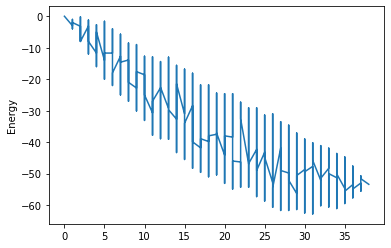

Best found: [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37]
count: 31
Energy: -62.79999999999999
Solutions Sampled: 67483


([0,
  1,
  2,
  3,
  4,
  6,
  7,
  8,
  10,
  11,
  12,
  13,
  15,
  16,
  17,
  18,
  20,
  22,
  23,
  24,
  25,
  27,
  28,
  29,
  30,
  31,
  32,
  34,
  35,
  36,
  37],
 -62.79999999999999,
 [1,
  38,
  702,
  8436,
  73815,
  501942,
  2760681,
  12620256,
  48903492,
  163011640,
  472733756,
  1203322288,
  2707475148,
  5414950296,
  9669554100,
  15471286560,
  22239974430,
  28781143380,
  33578000610,
  35345263800,
  33578000610,
  28781143380,
  22239974430,
  15471286560,
  9669554100,
  5414950296,
  2707475148,
  1203322288,
  472733756,
  163011640,
  48903492,
  12620256,
  2760681,
  501942,
  73815,
  8436,
  703,
  38,
  1])

In [110]:
ProbabilisticSampler(TN,2000)

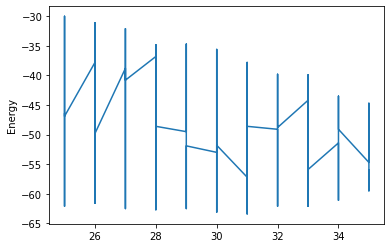

Best found: [1, 2, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37]
count: 31
Energy: -63.39999999999999
Solutions Sampled: 208436


([1,
  2,
  3,
  4,
  6,
  7,
  8,
  10,
  11,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  21,
  22,
  23,
  24,
  25,
  27,
  28,
  29,
  30,
  31,
  32,
  34,
  35,
  36,
  37],
 -63.39999999999999,
 [5414950296,
  2707475148,
  1203322288,
  472733756,
  163011640,
  48903492,
  12620256,
  2760681,
  501942,
  73815,
  8436])

In [111]:
ProbabilisticSampler(TN,20000,0,25,35)

Run on Aspen matrix A to compare values

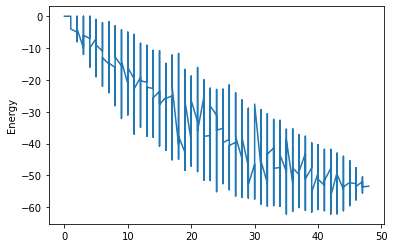

Best found: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47]
count: 42
Energy: -62.1
Solutions Sampled: 88354


([0,
  1,
  2,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  12,
  13,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  33,
  34,
  35,
  36,
  37,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47],
 -62.1,
 [1,
  48,
  1128,
  17296,
  194580,
  1712304,
  12271512,
  73629072,
  377348994,
  1677106640,
  6540715896,
  22595200368,
  69668534467,
  192928249295,
  482320623239,
  1093260079344,
  2254848913647,
  4244421484512,
  7309837001104,
  11541847896480,
  16735679449895,
  22314239266528,
  27385657281648,
  30957699535776,
  32247603683100,
  30957699535776,
  27385657281648,
  22314239266528,
  16735679449896,
  11541847896480,
  7309837001104,
  4244421484512,
  2254848913647,
  1093260079344,
  482320623240,
  192928249295,
  69668534468,
  22595200368,
  6540715896,
  1677106640,
  377348994,
  73629072,
  12271512,
  1712304,
  194580,
  17296,
  1128,
  48,
  1])

In [199]:
ProbabilisticSampler(A,2000)

Using simulated annealer

In [113]:
response=run_neal(TN)

Sample(sample={0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 0, 21: 1, 22: 1, 23: 0, 24: 1, 25: 1, 26: 0, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 0, 34: 0, 35: 1, 36: 1, 37: 1}, energy=-67.80000000000001, num_occurrences=1)
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 0, 21: 1, 22: 1, 23: 0, 24: 1, 25: 1, 26: 0, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 0, 34: 0, 35: 1, 36: 1, 37: 1}
11101011101101011111011011011111100111
253092542439


In [114]:
response=run_neal(A)

Sample(sample={0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0, 15: 1, 16: 0, 17: 1, 18: 0, 19: 0, 20: 1, 21: 1, 22: 1, 23: 1, 24: 0, 25: 1, 26: 1, 27: 0, 28: 0, 29: 0, 30: 1, 31: 1, 32: 0, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 0, 39: 0, 40: 0, 41: 0, 42: 1, 43: 0, 44: 0, 45: 1, 46: 1, 47: 1}, energy=-67.80000000000001, num_occurrences=1)
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0, 15: 1, 16: 0, 17: 1, 18: 0, 19: 0, 20: 1, 21: 1, 22: 1, 23: 1, 24: 0, 25: 1, 26: 1, 27: 0, 28: 0, 29: 0, 30: 1, 31: 1, 32: 0, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 0, 39: 0, 40: 0, 41: 0, 42: 1, 43: 0, 44: 0, 45: 1, 46: 1, 47: 1}
111010110110110101001111011000110111110000100111
258854715882535


In [ ]:
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 0, 21: 1, 22: 1, 23: 0, 24: 1, 25: 1, 26: 0, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 0, 34: 0, 35: 1, 36: 1, 37: 1}
11101011101101011111011011011111100111
253092542439

### Optimizing 50 x 50 sparse matrix

In [96]:
Q50=generate_sparse_matrix(50)

100
terms: 72


In [97]:
print(Q50)

[[-5.  0.  0. ...  0.  0.  0.]
 [ 0. -4.  0. ...  0.  0.  0.]
 [ 0.  0. -5. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -3.  0.  0.]
 [ 0.  0.  0. ...  0. -3.  0.]
 [ 0.  0.  0. ...  0.  0. -4.]]


In [135]:
print(param)

[0.2  0.25 0.3  0.35]


In [137]:
param1=np.arange(0.2,0.35,0.05,dtype=float)
param2=np.arange(0.3,0.4,0.05,dtype=float)
print(param1)
print(param2)

[0.2  0.25 0.3 ]
[0.3  0.35 0.4 ]


T   : |0|1|   2   |                           3                           |                           4                           |           5           |           6           |       7       |   8   |
                                                                                                                                                                                                           
q0  : -X-H-Rz(2)---ZZ(1.6)-------------------------------------------------ZZ(2)---------------------------------------------------Rx(0.6)-----------------------------------------------------------------
                   |                                                       |                                                                                                                               
q1  : -X-H-Rz(1.6)-|-------ZZ(1.6)-----------------------------------------|-------ZZ(2)-------------------------------------------Rx(0.6)----------------------------------------------

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 1000
simulator cost per  minute : $ 0.275
total execution time:  76389 ms
total cost estimated: $ 0.35011625
{727857834061435: 1, 139396171882109: 1, 700336012332889: 1, 281280629308665: 1, 225013051817457: 1, 586588311408368: 1, 594816685435901: 1, 640446522947738: 1, 605571248645536: 1, 482513047191001: 1, 280871790554361: 1, 123504972256995: 1, 629887981088504: 1, 1078877798811321: 1, 273907177025496: 1, 892115423985107: 1, 865297195978209: 1, 952674874764541: 1, 573938828430982: 1, 91790226438108: 1, 138520133876213: 1, 535125536175355: 1, 849727526529264: 1, 1074007463374651: 1, 96145986027001: 1, 1114594669328371: 1, 1079544852081397: 1, 1099850787581654: 1, 444855491219832: 1, 163635227196671: 1, 91116184757950: 1, 1077933702999984: 1, 130131770602903: 1, 1009324561967061: 1, 64701926342386: 1, 65915539

T   : |0|1|   2   |                           3                           |                           4                           |           5           |           6           |       7       |   8   |
                                                                                                                                                                                                           
q0  : -X-H-Rz(2)---ZZ(1.6)-------------------------------------------------ZZ(2)---------------------------------------------------Rx(0.7)-----------------------------------------------------------------
                   |                                                       |                                                                                                                               
q1  : -X-H-Rz(1.6)-|-------ZZ(1.6)-----------------------------------------|-------ZZ(2)-------------------------------------------Rx(0.7)----------------------------------------------

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 1000
simulator cost per  minute : $ 0.275
total execution time:  61450 ms
total cost estimated: $ 0.2816458333333333
{629280847392353: 1, 1043947903237756: 1, 243378611615485: 1, 597032992468220: 1, 499143304273865: 1, 881695307425772: 1, 279979696596981: 1, 940459322846328: 1, 946102291918198: 1, 136112866707063: 1, 658701750873334: 1, 732761105058936: 1, 876684865468149: 1, 878989685883833: 1, 288541904313456: 1, 25259267248117: 1, 628886182257877: 1, 877391145685998: 1, 940045388539313: 1, 727171833097361: 1, 629296634765053: 1, 857789717014655: 1, 879007886593789: 1, 695969577303548: 1, 1099434718782204: 1, 4508297653908: 1, 1046007337973218: 1, 901972381099222: 1, 829357838281840: 1, 32397944258298: 1, 662317510724775: 1, 442929906974429: 1, 904880880158971: 1, 25097815228016: 1, 754776881319165: 1, 82821

T   : |0|1|   2   |                           3                           |                           4                           |           5           |           6           |       7       |   8   |
                                                                                                                                                                                                           
q0  : -X-H-Rz(2)---ZZ(1.6)-------------------------------------------------ZZ(2)---------------------------------------------------Rx(0.8)-----------------------------------------------------------------
                   |                                                       |                                                                                                                               
q1  : -X-H-Rz(1.6)-|-------ZZ(1.6)-----------------------------------------|-------ZZ(2)-------------------------------------------Rx(0.8)----------------------------------------------

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 1000
simulator cost per  minute : $ 0.275
total execution time:  60099 ms
total cost estimated: $ 0.27545375
{210104663961335: 1, 479743742602487: 1, 949967733780222: 1, 92769875312377: 1, 68079173730042: 1, 482633702178276: 1, 280116881124575: 1, 939394701009983: 1, 774037658140157: 1, 843685908410108: 1, 409754373189361: 1, 1080097837788633: 1, 1081625435008510: 1, 90828591300081: 1, 553550855532534: 1, 595248105254881: 1, 129001679087097: 1, 90104535875574: 1, 518829968813565: 1, 393744298893041: 1, 316108444658909: 1, 511624007908604: 1, 482496614886647: 1, 65361147720182: 1, 551542184079321: 1, 806846364904561: 1, 770301030923737: 1, 552914155450329: 1, 768394334269317: 1, 942382557186285: 1, 139475101367733: 1, 67583443070328: 1, 483526603599600: 1, 878353558529257: 1, 483218020466424: 1, 69818984791544:

T   : |0|1|   2   |                          3                          |                          4                          |           5           |          6          |       7       |   8   |
                                                                                                                                                                                                     
q0  : -X-H-Rz(2.5)-ZZ(2)-------------------------------------------------ZZ(2.5)-----------------------------------------------Rx(0.6)---------------------------------------------------------------
                   |                                                     |                                                                                                                           
q1  : -X-H-Rz(2)---|-------ZZ(2)-----------------------------------------|-------ZZ(2.5)---------------------------------------Rx(0.6)---------------------------------------------------------------
          

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 1000
simulator cost per  minute : $ 0.275
total execution time:  61556 ms
total cost estimated: $ 0.28213166666666667
{866770006663164: 1, 304701588228341: 1, 704219145244645: 1, 411709624379618: 1, 1094041624083794: 1, 979109723631357: 1, 411574220451545: 1, 761230397921084: 1, 482599085653206: 1, 549148192762096: 1, 306593251294948: 1, 237386698387187: 1, 385746447003641: 1, 976313105895129: 1, 10324755184337: 1, 936180794748026: 1, 350516023471324: 1, 102226855328244: 1, 728185269514202: 1, 379279375846633: 1, 937831262547076: 1, 270392344144216: 1, 291280655445884: 1, 738078773177470: 1, 982355819392756: 1, 148274542890424: 1, 34888471656947: 1, 117337958542558: 1, 193341636664446: 1, 698282973949404: 1, 429310032210168: 1, 926268406640058: 1, 685123743214812: 1, 938570586284786: 1, 448338726317147: 1, 974

T   : |0|1|   2   |                          3                          |                          4                          |           5           |          6          |       7       |   8   |
                                                                                                                                                                                                     
q0  : -X-H-Rz(2.5)-ZZ(2)-------------------------------------------------ZZ(2.5)-----------------------------------------------Rx(0.7)---------------------------------------------------------------
                   |                                                     |                                                                                                                           
q1  : -X-H-Rz(2)---|-------ZZ(2)-----------------------------------------|-------ZZ(2.5)---------------------------------------Rx(0.7)---------------------------------------------------------------
          

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 1000
simulator cost per  minute : $ 0.275
total execution time:  54683 ms
total cost estimated: $ 0.25063041666666663
{553568093695481: 1, 936179640657853: 1, 649656468379898: 1, 843192473089144: 1, 730024007298798: 1, 1115282668337656: 1, 974604437159158: 1, 103885046615777: 1, 866920626419673: 1, 379689837643744: 1, 164359470149332: 1, 551384878234600: 1, 667652388792063: 1, 1081626609326335: 1, 303138117334525: 1, 833926676638972: 1, 680183385238712: 1, 653555967053052: 1, 443324105723056: 1, 409391843306680: 1, 194509861653292: 1, 901684561539069: 1, 412677597490221: 1, 967002485450996: 1, 1081180150966504: 1, 133546627418096: 1, 551279906914302: 1, 585350607858918: 1, 832825564932338: 1, 278307706628603: 1, 340108175032830: 1, 1046012639440084: 1, 657579112201372: 1, 447999305575930: 1, 456382618270958: 1

T   : |0|1|   2   |                          3                          |                          4                          |           5           |          6          |       7       |   8   |
                                                                                                                                                                                                     
q0  : -X-H-Rz(2.5)-ZZ(2)-------------------------------------------------ZZ(2.5)-----------------------------------------------Rx(0.8)---------------------------------------------------------------
                   |                                                     |                                                                                                                           
q1  : -X-H-Rz(2)---|-------ZZ(2)-----------------------------------------|-------ZZ(2.5)---------------------------------------Rx(0.8)---------------------------------------------------------------
          

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 1000
simulator cost per  minute : $ 0.275
total execution time:  71452 ms
total cost estimated: $ 0.3274883333333333
{280889173943545: 1, 385869766323824: 1, 552882340194558: 1, 789706276941308: 1, 378230621367419: 1, 446825301863549: 1, 682005565404780: 1, 591932043126969: 1, 667889423445233: 1, 243490067152248: 1, 831740002697208: 1, 839462311415788: 1, 825097196482004: 1, 904174828350608: 1, 103710361743084: 1, 426970403654202: 1, 57273161809144: 1, 836710354579164: 1, 621185908699075: 1, 95045939590652: 1, 85033371922032: 1, 562877439502306: 1, 121872305712376: 1, 270692986121401: 1, 934583236119292: 1, 772144541361340: 1, 306038084955356: 1, 803519044365535: 1, 1080097745750268: 1, 816334975237373: 1, 377620434022132: 1, 590230771298297: 1, 234570444058609: 1, 517148059200752: 1, 921268520300540: 1, 86979

T   : |0|1|   2   |                           3                           |                           4                           |           5           |           6           |       7       |   8   |
                                                                                                                                                                                                           
q0  : -X-H-Rz(3)---ZZ(2.4)-------------------------------------------------ZZ(3)---------------------------------------------------Rx(0.6)-----------------------------------------------------------------
                   |                                                       |                                                                                                                               
q1  : -X-H-Rz(2.4)-|-------ZZ(2.4)-----------------------------------------|-------ZZ(3)-------------------------------------------Rx(0.6)----------------------------------------------

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 1000
simulator cost per  minute : $ 0.275
total execution time:  57154 ms
total cost estimated: $ 0.26195583333333333
{618413969919188: 1, 517008188059051: 1, 455505044494525: 1, 877907862160639: 1, 623789302180060: 1, 552209999122918: 1, 479467872218793: 1, 947174946994870: 1, 921762722572668: 1, 868012245077757: 1, 789826653074684: 1, 692948180008684: 1, 917475549980911: 1, 939481122024957: 1, 939300626984372: 1, 685080020250049: 1, 963975551738111: 1, 114289010101340: 1, 277609457233580: 1, 548088248401661: 1, 1062641847845108: 1, 1109215089913080: 1, 939480761593404: 1, 218799850487546: 1, 939663611686328: 1, 1115126236146923: 1, 130013461773556: 1, 197985627827805: 1, 1063207742830844: 1, 902108755125887: 1, 808632414203188: 1, 218191023713405: 1, 808638410078397: 1, 374632144412330: 1, 1113635008358878: 

T   : |0|1|   2   |                           3                           |                           4                           |           5           |           6           |       7       |   8   |
                                                                                                                                                                                                           
q0  : -X-H-Rz(3)---ZZ(2.4)-------------------------------------------------ZZ(3)---------------------------------------------------Rx(0.7)-----------------------------------------------------------------
                   |                                                       |                                                                                                                               
q1  : -X-H-Rz(2.4)-|-------ZZ(2.4)-----------------------------------------|-------ZZ(3)-------------------------------------------Rx(0.7)----------------------------------------------

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 1000
simulator cost per  minute : $ 0.275
total execution time:  63749 ms
total cost estimated: $ 0.2921829166666667
{92444335531748: 1, 235585932852948: 1, 1081321762022654: 1, 139447344855068: 1, 411659181878344: 1, 66465045114748: 1, 228096582445301: 1, 939137198025932: 1, 1063169751338429: 1, 568890929515036: 1, 1045587740182781: 1, 376977323194856: 1, 876696441795581: 1, 412115522927784: 1, 864748078182269: 1, 411440115542260: 1, 154350082876572: 1, 940046690888829: 1, 1113752923400156: 1, 304504005585340: 1, 404978293730524: 1, 604954562492719: 1, 870241333014000: 1, 244863050015996: 1, 970161395330284: 1, 655686068693240: 1, 514794671139044: 1, 904157452347640: 1, 767814791424252: 1, 304563033040094: 1, 666612463922412: 1, 377084696292836: 1, 1062484636411384: 1, 410494145260604: 1, 1011532173257145: 1,

T   : |0|1|   2   |                           3                           |                           4                           |           5           |           6           |       7       |   8   |
                                                                                                                                                                                                           
q0  : -X-H-Rz(3)---ZZ(2.4)-------------------------------------------------ZZ(3)---------------------------------------------------Rx(0.8)-----------------------------------------------------------------
                   |                                                       |                                                                                                                               
q1  : -X-H-Rz(2.4)-|-------ZZ(2.4)-----------------------------------------|-------ZZ(3)-------------------------------------------Rx(0.8)----------------------------------------------

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 1000
simulator cost per  minute : $ 0.275
total execution time:  54518 ms
total cost estimated: $ 0.24987416666666665
{851329548778748: 1, 448272176342752: 1, 372887374867964: 1, 92732009049258: 1, 130755303301564: 1, 939480270519533: 1, 136835971338220: 1, 1111286536591612: 1, 772799259602172: 1, 1080525982625533: 1, 981261169716476: 1, 666801394788596: 1, 655659229335145: 1, 412127233073394: 1, 385343383107765: 1, 656906423463664: 1, 799344354142584: 1, 1007512612498476: 1, 289669771520236: 1, 655660839037116: 1, 374194118691168: 1, 377371392567518: 1, 271939434015900: 1, 136699567271678: 1, 922421276470524: 1, 842465808869588: 1, 658967166807292: 1, 24670188676860: 1, 937281507944180: 1, 374336167210456: 1, 389759579286712: 1, 101446577365558: 1, 515079846846584: 1, 102785974889976: 1, 917484664612092: 1, 5

0.2 0.39999999999999997 -113.0


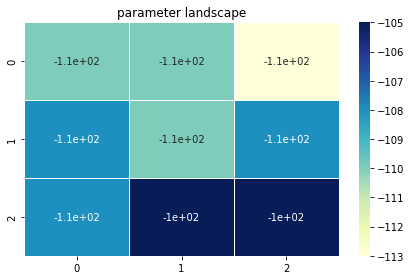

In [138]:
ideal_param1, ideal_param2, lowest_energy=param_optimizer_device(param1, param2, Q50, 1000,'TN1')
print(ideal_param1, ideal_param2, lowest_energy)

In [ ]:
#---------
param1=[0.1,0.1,0.1,0.1]
param2=[0.23,0.23,0.23,0.23]
shots=1000
#---------
device=set_device('TN1')
task_id=schedule_optimize_bqm_task(param1, param2, Q50, shots, device)
print(task_id)

1000 shots taken on machine arn:aws:braket:::device/quantum-simulator/amazon/tn1.


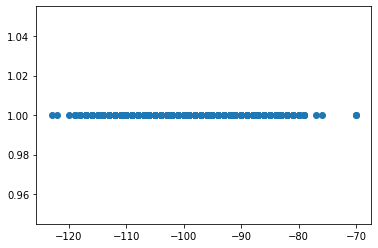

minimum found -123.0
simulator cost per  minute : $ 0.275
total execution time:  232146 ms
total cost estimated: $ 1.0640025


In [206]:
results, metadata, counts=recover_task(task_id)
solution=[]
quantity=[]
energy=[]
for keys,values in zip(counts.keys(),counts.values()):
    solution.append(keys)
    quantity.append(values)
    energy.append(sum_energy(Q50,keys))
index=np.argsort(energy)
plt.scatter(energy,quantity)
plt.show()
print('minimum found', energy[index[0]])
actual_simulator_cost(device, results)

In [82]:
response=run_dwave(Q50)

Number of qubits:  5760
Number of couplers 40279
Shots max 10,000
28147497671065600
Recommended shots 10000
Estimated cost $2.20
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 ... 49 energy num_oc. ...
0     0  1  1  0  0  1  0  1  1  0  0  1  1  1  1  1 ...  1 -130.0      87 ...
1     0  1  1  0  0  1  0  1  1  0  0  1  1  1  1  1 ...  1 -130.0      74 ...
2     0  1  1  0  0  1  0  1  1  0  0  1  1  1  1  1 ...  1 -130.0     163 ...
3     0  1  1  0  0  1  0  1  1  0  0  1  1  1  1  1 ...  1 -130.0     162 ...
4     0  1  1  0  0  1  0  1  1  0  1  1  1  1  0  1 ...  1 -130.0     175 ...
5     0  1  1  0  0  1  0  1  1  0  1  1  1  1  0  1 ...  1 -130.0     130 ...
6     0  1  1  0  0  1  0  1  1  0  1  1  1  1  0  1 ...  1 -130.0     106 ...
7     0  1  1  0  0  1  0  1  1  0  1  1  1  1  0  1 ...  1 -130.0      92 ...
8     0  1  1  0  0  1  0  1  1  0  0  1  1  1  1  1 ...  1 -130.0      15 ...
9     0  1  1  0  0  1  0  1  1  0  0  1  1  1  1  1 ...  1 -130.0      14 ...
10

In [83]:
response=run_neal(Q50)

Sample(sample={0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 0, 24: 1, 25: 1, 26: 1, 27: 1, 28: 0, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 0, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 0, 47: 0, 48: 1, 49: 1}, energy=-130.0, num_occurrences=1)
{0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 0, 24: 1, 25: 1, 26: 1, 27: 1, 28: 0, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 0, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 0, 47: 0, 48: 1, 49: 1}
01100101100111111111111011110111111111110111110011
446951407484403


### Optimizing 100x100 matrix

In [209]:
Q100=generate_matrix(100)

100


In [210]:
response=run_dwave(Q100)

Number of qubits:  5760
Number of couplers 40279
Shots max 10,000
31691265005705735037417580134400
Recommended shots 10000
Estimated cost $2.20
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 ... 99 energy num_oc. ...
1268  0  0  0  0  1  0  0  0  0  1  0  0  0  1  0  0 ...  0  189.0       1 ...
846   0  0  0  0  1  0  0  0  0  1  0  0  0  1  0  0 ...  0  190.0       1 ...
1494  0  0  0  0  1  0  0  0  0  1  0  0  0  1  0  0 ...  0  194.0       1 ...
9153  1  0  0  1  0  0  0  0  0  0  1  1  0  0  0  0 ...  0  194.0       1 ...
2784  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0 ...  0  196.0       1 ...
2870  0  0  0  0  1  0  0  0  0  1  0  0  0  1  0  0 ...  0  202.0       1 ...
3322  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0 ...  0  202.0       1 ...
7660  1  0  0  1  0  0  1  0  0  0  1  0  0  0  0  0 ...  0  202.0       1 ...
5159  1  0  0  1  0  0  1  0  0  0  1  1  0  0  0  0 ...  0  203.0       1 ...
4294  1  0  0  1  0  0  1  0  0  0  1  0  0  0  0  0 ...  0  206.0

In [211]:
response=run_neal(Q100)

Sample(sample={0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 1, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 1, 85: 0, 86: 0, 87: 1, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 1, 97: 0, 98: 0, 99: 0}, energy=-14.0, num_occurrences=1)
{0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 1, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 

In [ ]:
------------------------------------- End --------------------------